In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
from scipy.ndimage import gaussian_filter


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
import matplotlib.patches as mpatches

import sys

p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import *
from orographicPrecipitation.smith_lm import full_linear_model_saturated_monthly

from pandas.tseries.offsets import MonthEnd
from xarray.ufuncs import cos, deg2rad


/global/u2/q/qnicolas/orographicPrecipitation/precipRegions


In [2]:
def mean_era5(year1,year2,varid,mnth=""):
    """Compute the monthly climatology of a 3D or 4D ERA5 variable for years between year1 and year2 (included),
    year1/2 must be of the type "yyyy"
    varid gives the id of the variable in era5, e.g. '128_135_w' for omega
    mnth is an str that gives the month to be considered
    """
    path = "/global/project/projectdirs/m3310/wboos/era5monthly/"
    
    era5varsum = 0
    count = int(year2)+1-int(year1)
    era5varlist = []
    for y in [str(year) for year in range(int(year1),int(year2)+1)]:
        era5var = xr.open_dataset(glob.glob(path+"*/e5.mnth.mean.an.*.%s.*.%s*.nc"%(varid,y))[0])
        varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'W' for omega
        if len(mnth)>0:
            era5var1 = era5var[varname].sel(time=pd.to_datetime(y+mnth,format='%Y%m'))
        else :
            era5var1 = era5var[varname].mean("time")
        era5varsum += era5var1
        era5varlist.append(era5var1)
    #climatology = xr.concat(era5varlist,"time").groupby("time.month").mean("time")
    return era5varsum/count#climatology#

def spatial_mean(ds):
    """Compute spatial mean of a Dataset"""
    coslat = cos(deg2rad(ds.latitude))
    weight_factor = coslat / coslat.mean('latitude')
    return (ds*weight_factor).mean(['latitude','longitude'])

def spatial_integ(ds):
    """Compute spatial integral of a Dataset"""
    coslat = cos(deg2rad(ds.latitude))
    return (6370e3)**2*(ds*coslat).sum(['latitude','longitude'])

# Precip climatologies

## Precipitation climatology, TRMM

In [3]:
pr_trmm=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr*3600*24
pr_trmm_mean = pr_trmm.mean("time")

Text(0.5, 1.0, '1998-2013 mean precip, TRMM, mm/day')

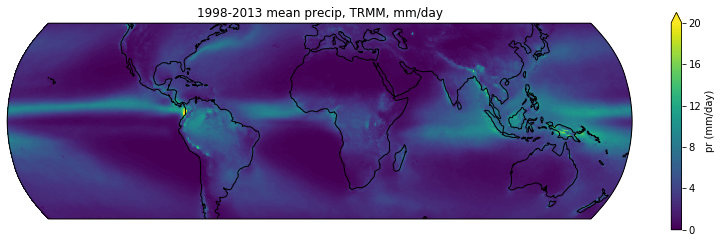

In [4]:
plt.figure(figsize=(14,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pr_trmm_mean.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax.set_title("1998-2013 mean precip, TRMM, mm/day")

## 99th percentile of daily precipitation, climatology, TRMM

In [5]:
pr_trmm_99th=xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/pr_trmm_99pctile_2010-2013.nc").pr*3600*24


Text(0.5, 1.0, '2010-2013 precip 99th percentile, TRMM, mm/day')

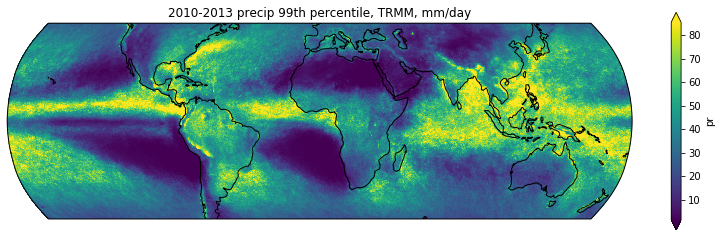

In [6]:
plt.figure(figsize=(14,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pr_trmm_99th.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True)
ax.set_title("2010-2013 precip 99th percentile, TRMM, mm/day")

## Precipitation climatology, ERA5

In [4]:
ERA5M_PATH = "/global/project/projectdirs/m3310/wboos/era5monthly/"
pr_era5_all = 1000*xr.open_dataset(ERA5M_PATH+"era5_monthly_slev_1979-2019.nc").tp
pr_era5_mean = pr_era5_all.mean("time")

In [5]:
def timesel(year,month,monthinf,monthsup):
    return (year >= 2008) & (year <= 2017) & (np.mod(month - monthinf,12) < np.mod(monthsup - monthinf,12)) & (np.mod(monthsup - month,12) <= np.mod(monthsup - monthinf,12))

pr_era5_mean_jan = pr_era5_all.sel(time = timesel(pr_era5_all['time.year'],pr_era5_all['time.month'],1,2)).mean("time")
pr_era5_mean_jul = pr_era5_all.sel(time = timesel(pr_era5_all['time.year'],pr_era5_all['time.month'],7,8)).mean("time")

pr_era5_mean_JJA = pr_era5_all.sel(time = timesel(pr_era5_all['time.year'],pr_era5_all['time.month'],6,9)).mean("time")
pr_era5_mean_DJF = pr_era5_all.sel(time = timesel(pr_era5_all['time.year'],pr_era5_all['time.month'],12,3)).mean("time")
pr_era5_mean_MAM = pr_era5_all.sel(time = timesel(pr_era5_all['time.year'],pr_era5_all['time.month'],3,6)).mean("time")
pr_era5_mean_SON = pr_era5_all.sel(time = timesel(pr_era5_all['time.year'],pr_era5_all['time.month'],9,12)).mean("time")



Text(0.5,1,'2010-2013 mean precip, ERA5, mm/day')

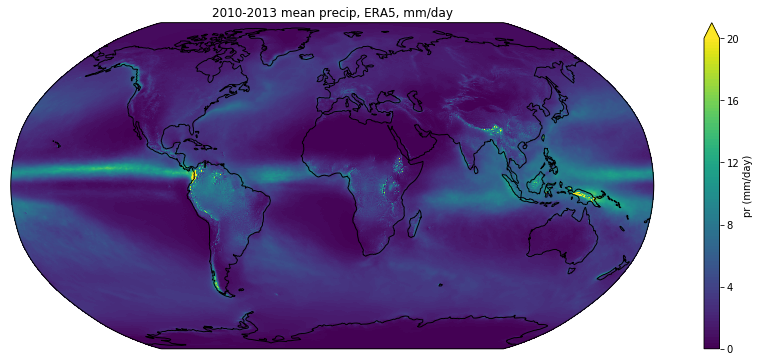

In [11]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pr_era5_mean.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax.set_title("2010-2013 mean precip, ERA5, mm/day")

In [4]:
pr_era5_99th = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/ERA5_IVT_tp_reanalysis_99pctile_2010.nc").tp


Text(0.5,1,'2010 precip 99th pctile, ERA5, mm/day')

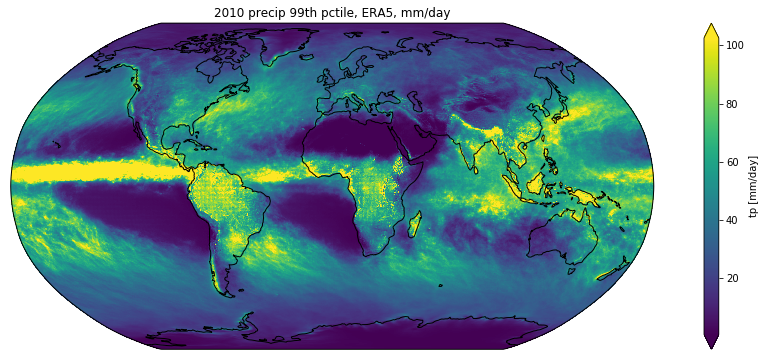

In [13]:

plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
pr_era5_99th.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True)#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,91.,10.)},levels=np.linspace(0.,90.,100))
ax.set_title("2010 precip 99th pctile, ERA5, mm/day")

                                
                                

## (TRMM minus ERA5)/ERA5

Text(0.5,1,'Relative error on 2010-2013 mean precip, TRMM vs ERA5')

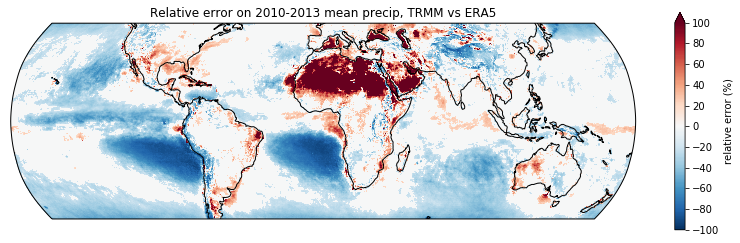

In [14]:
pr_trmm_mean2 = pr_trmm_mean.rename({'lat': 'latitude','lon': 'longitude'})
pr_era5_mean2 = pr_era5_mean.sel(latitude=slice(50., -50.)).interp_like(pr_trmm_mean2)
ratio = 100*(pr_trmm_mean2-pr_era5_mean2)/pr_era5_mean2

ratio = ratio*(abs(ratio)>20)

plt.figure(figsize=(14,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ratio.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"relative error (%)","ticks":np.arange(-100,101,20)},levels=np.linspace(-100.,100.,200))
ax.set_title("Relative error on 2010-2013 mean precip, TRMM vs ERA5")


Text(0.5,1,'Relative error on 99th percentile of precip, TRMM vs ERA5')

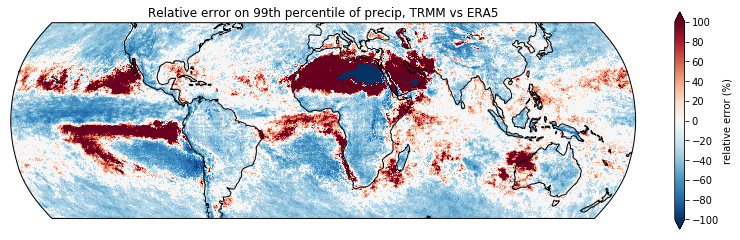

In [15]:
pr_trmm_99th2 = pr_trmm_99th.rename({'lat': 'latitude','lon': 'longitude'})
pr_era5_99th2 = pr_era5_99th.sel(latitude=slice(50., -50.)).interp_like(pr_trmm_99th2)
ratio99th = 100*(pr_trmm_99th2-pr_era5_99th2)/pr_era5_99th2

ratio99th = ratio99th*(abs(ratio99th)>20)

plt.figure(figsize=(14,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ratio99th.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"relative error (%)","ticks":np.arange(-100,101,20)},levels=np.linspace(-100.,100.,200))
ax.set_title("Relative error on 99th percentile of precip, TRMM vs ERA5")


# Applying the OG scaling to mean fields

In [4]:
def scaling3(omega, temp, ps):
    """Same as scaling, but the arguments are sorted by increasing pressure and plevs are already input
    scaling3 is to be vectorized by xarray"""
    #Pressure levels from era5
    allplevs = 100.*np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
    
    return scaling(omega[::-1], temp[::-1], allplevs[::-1], ps)

def precip_model_OGorman_mean(year1,year2, mnth,regrid=0,resolution=1.):
    """compute monthly mean precip climatology between year1 and year2, for a given month
        with O'Gorman & Schneider model
        with two models for omega : omega from ERA5, and upslope omega
    """
    t0=time.time()
        
    #temp,ps, omega
    t = time.time()
    temp = mean_era5(year1,year2,'128_130_t' , mnth)
    ps   = mean_era5(year1,year2,'128_134_sp', mnth)
    omega= mean_era5(year1,year2,'128_135_w' , mnth)
    print("elapsed time / temperature, sfc pressure, omega : ", time.time()-t) 
    
    if regrid :
        ds_out = xr.Dataset({'latitude': (['latitude'], np.arange(90-resolution/2,-90,-resolution)),
                     'longitude': (['longitude'], np.arange(0,360,resolution)),
                    }
                   )
        temp =temp.interp_like(ds_out)
        ps   =ps.interp_like(ds_out)
        omega=omega.interp_like(ds_out)
    
    #upslope omega
    t = time.time()
    ddx1=ddxorog_s.isel(time=0).interp_like(ps)
    ddy1=ddyorog_s.isel(time=0).interp_like(ps)
    u = mean_era5(year1,year2,'128_131_u',mnth)
    v = mean_era5(year1,year2,'128_132_v',mnth)
    if regrid : 
        u   =u.interp_like(ds_out)
        v   =v.interp_like(ds_out)
    wupslope = u*ddx1+v*ddy1
    print("elapsed time / upslope omega : ", time.time()-t) 

    pr_omegaERA5 = np.maximum(24*3600*xr.apply_ufunc(scaling3,omega,temp,ps,input_core_dims=[['level'], ['level'],[]],vectorize=True),0.)
    omegaupslope = upslope_omega_sin(ps,wupslope)
    pr_omegaupslope = np.maximum(24*3600*xr.apply_ufunc(scaling3,omegaupslope,temp,ps,input_core_dims=[['level'], ['level'],[]],vectorize=True),0.)
    
    print("Total time : ", time.time()-t0)
    return pr_omegaERA5,pr_omegaupslope

In [18]:
#pr_omegaERA5,pr_omegaupslope = precip_model_OGorman_mean("2010","2013", "07",regrid=1,resolution=2.)


In [19]:
#pr_omegaERA5.attrs['units']="mm/day"
#pr_omegaERA5.attrs['description']="Precipitation as computed by the O'Gorman and Schneider scaling, with omega, temperature and surface pressure taken from ERA5 and averaged over 2010-2013"
#pr_omegaERA5.to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaERA5Xqinteg.2deg.2010-2013.07.global.nc")
#
#pr_omegaupslope.attrs['units']="mm/day"
#pr_omegaupslope.attrs['description']="Precipitation as computed by the O'Gorman and Schneider scaling, with temperature and surface pressure taken from ERA5 and averaged over 2010-2013, and upslope omega"
#pr_omegaupslope.to_netcdf("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaupslopeXqinteg.2deg.2010-2013.07.global.nc")


### Results

In [20]:
pr_omegaERA5_jan = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaERA5Xqinteg.2010-2013.01.global.nc").__xarray_dataarray_variable__
pr_omegaupslope_jan = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaupslopeXqinteg.2010-2013.01.global.nc").__xarray_dataarray_variable__

pr_omegaERA5_jan_2deg = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaERA5Xqinteg.2deg.2010-2013.01.global.nc").__xarray_dataarray_variable__
pr_omegaupslope_jan_2deg = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaupslopeXqinteg.2deg.2010-2013.01.global.nc").__xarray_dataarray_variable__

pr_omegaERA5_jul = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaERA5Xqinteg.2010-2013.07.global.nc").__xarray_dataarray_variable__
pr_omegaupslope_jul = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaupslopeXqinteg.2010-2013.07.global.nc").__xarray_dataarray_variable__

pr_omegaERA5_jul_2deg = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaERA5Xqinteg.2deg.2010-2013.07.global.nc").__xarray_dataarray_variable__
pr_omegaupslope_jul_2deg = xr.open_dataset("/global/cscratch1/sd/qnicolas/precipmodel/pr.omegaupslopeXqinteg.2deg.2010-2013.07.global.nc").__xarray_dataarray_variable__

In [21]:
pr_omegaERA5        = pr_omegaERA5_jan        
pr_omegaupslope     = pr_omegaupslope_jan     
pr_omegaERA5_2deg   = pr_omegaERA5_jan_2deg   
pr_omegaupslope_2deg= pr_omegaupslope_jan_2deg

Text(0.5,1,'same with a 2° gridding')

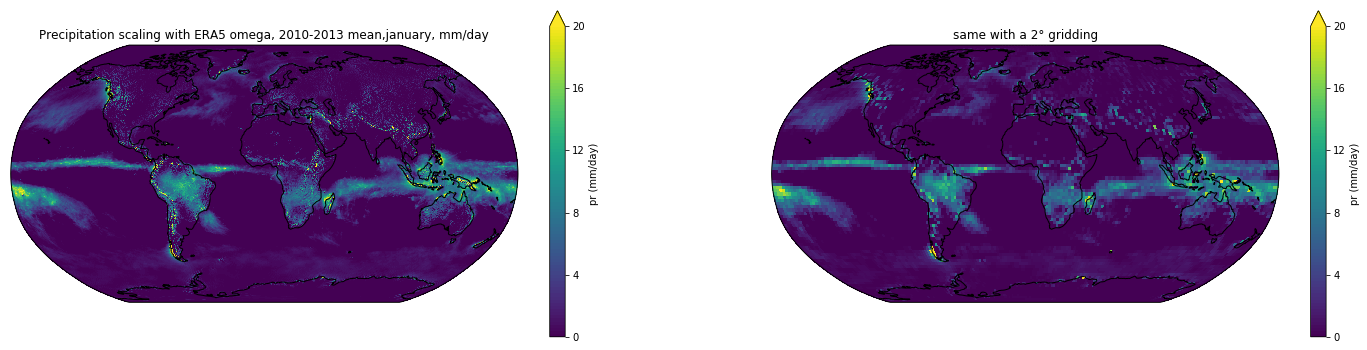

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
pr_omegaERA5.plot(     ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
pr_omegaERA5_2deg.plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("Precipitation scaling with ERA5 omega, 2010-2013 mean,january, mm/day");ax2.set_title("same with a 2° gridding")


Text(0.5,1,'coarsening after scaling minus before scaling')

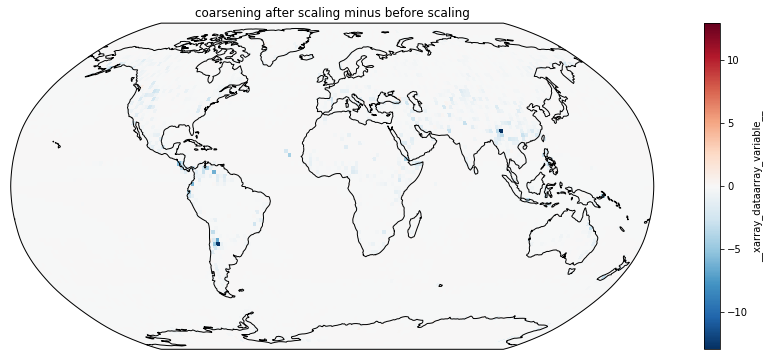

In [23]:
diff = pr_omegaERA5_2deg - pr_omegaERA5.interp_like(pr_omegaERA5_2deg)
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
diff.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title("coarsening after scaling minus before scaling")

Text(0.5,1,'same with a 2° gridding')

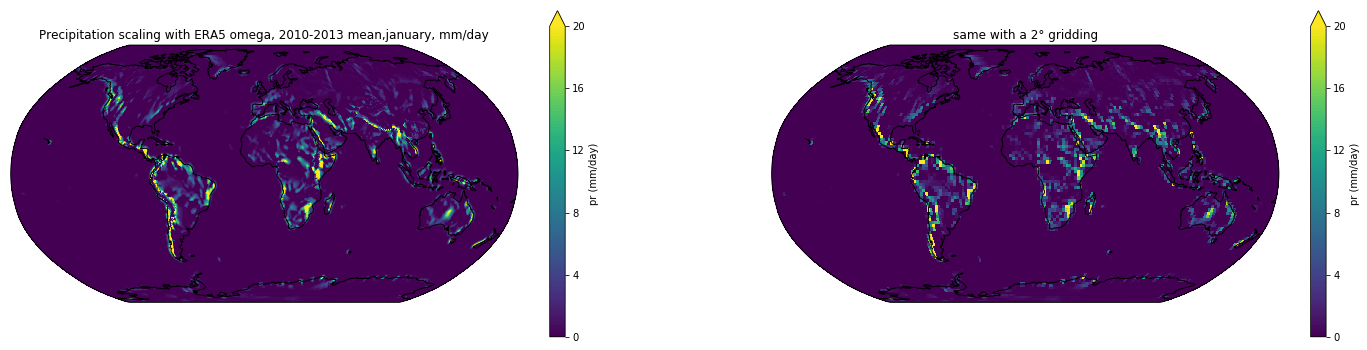

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
pr_omegaupslope.plot(     ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
pr_omegaupslope_2deg.plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("Precipitation scaling with ERA5 omega, 2010-2013 mean,january, mm/day");ax2.set_title("same with a 2° gridding")


Text(0.5,1,'coarsening after scaling minus before scaling')

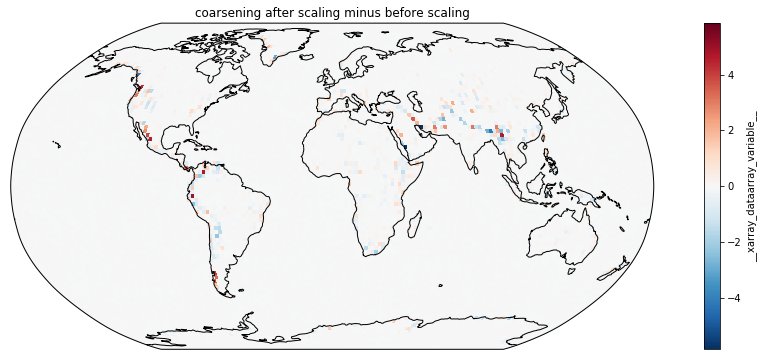

In [25]:
diff = pr_omegaupslope_2deg - pr_omegaupslope.interp_like(pr_omegaupslope_2deg)
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
diff.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title("coarsening after scaling minus before scaling")

## MASK

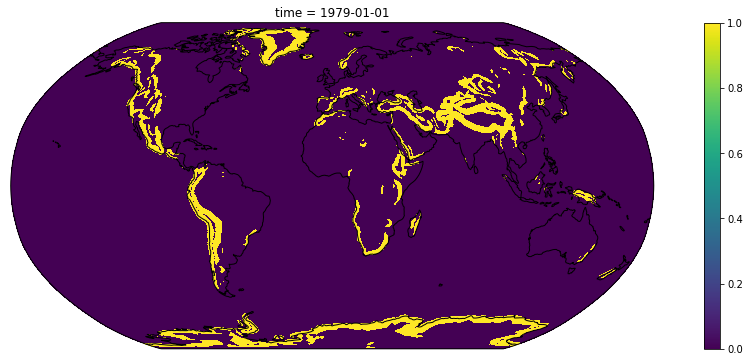

In [7]:
ddx1=ddxorog_s.isel(time=0)
ddy1=ddyorog_s.isel(time=0)

mask = 1.*((ddx1**2+ddy1**2)>1e-5)
plt.figure(figsize=(18,6)); ax = plt.axes(projection=ccrs.Robinson()); ax.coastlines()
mask.plot(ax=ax,transform=ccrs.PlateCarree())


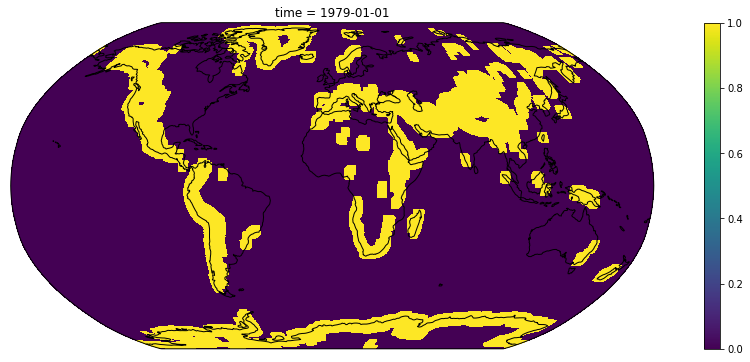

In [8]:
mask2 = 1.*(xr.apply_ufunc(gaussian_filter,mask,kwargs={"sigma":2.}) > 0)
plt.figure(figsize=(18,6)); ax = plt.axes(projection=ccrs.Robinson()); ax.coastlines()
mask2.plot(ax=ax,transform=ccrs.PlateCarree())

## Visual comparison

Precip efficiency factor :
0.9266969871923796


Text(0.5,1,'upslope precip, 2010-2013 mean,january')

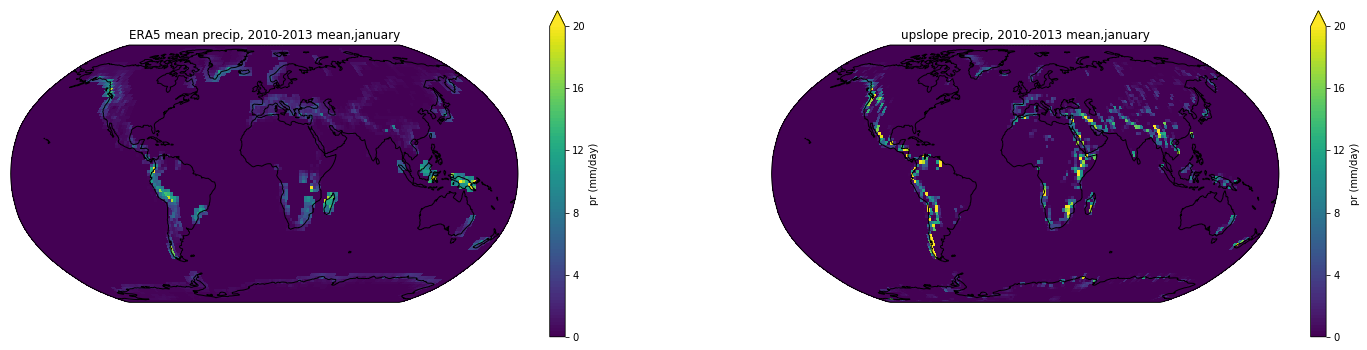

In [29]:
pr_era5_mean_jan2 = mask2.interp_like(pr_omegaupslope_jan_2deg)*pr_era5_mean_jan.interp_like(pr_omegaupslope_jan_2deg)
pr_era5_mean_jan2 = pr_era5_mean_jan2*(pr_era5_mean_jan2>0.)
pr_omegaupslope_jan2 = mask2.interp_like(pr_omegaupslope_jan_2deg)*pr_omegaupslope_jan.interp_like(pr_omegaupslope_jan_2deg)

print("Precip efficiency factor :")
PE = np.array(pr_era5_mean_jan2.sum(["latitude","longitude"]))/np.array(pr_omegaupslope_jan2.sum(["latitude","longitude"]))
print(PE)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
pr_era5_mean_jan2.plot(   ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
(PE*pr_omegaupslope_jan2).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("ERA5 mean precip, 2010-2013 mean,january");ax2.set_title("upslope precip, 2010-2013 mean,january")





Text(0.5,1,'Relative error on 2010-2013 JANUARY mean precip, ERA5 vs upslope')

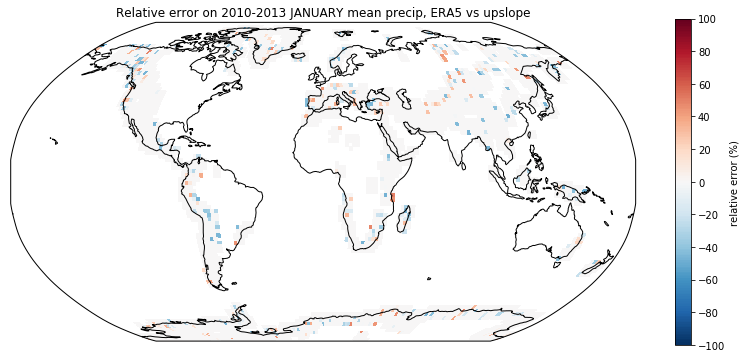

In [30]:
ratio = 100*(PE*pr_omegaupslope_jan2-pr_era5_mean_jan2)/pr_era5_mean_jan2

ratio = ratio*(abs(ratio)<50)

plt.figure(figsize=(14,6));ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
ratio.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"relative error (%)","ticks":np.arange(-100,101,20)},levels=np.linspace(-100.,100.,200))
ax.set_title("Relative error on 2010-2013 JANUARY mean precip, ERA5 vs upslope")

## July

Precip efficiency factor :
0.8648978801120447


Text(0.5,1,'upslope precip, 2010-2013 mean,july')

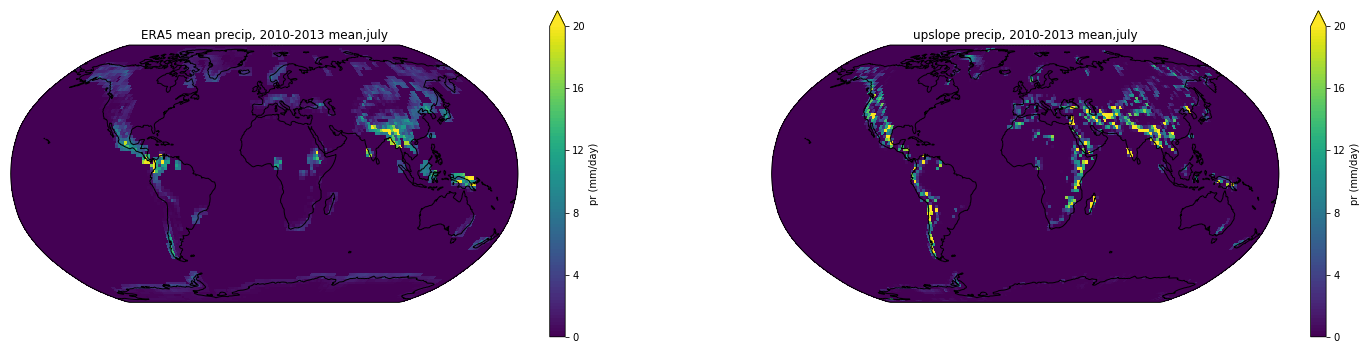

In [31]:
pr_era5_mean_jul2 = mask2.interp_like(pr_omegaupslope_jul_2deg)*pr_era5_mean_jul.interp_like(pr_omegaupslope_jul_2deg)
pr_era5_mean_jul2 = pr_era5_mean_jul2*(pr_era5_mean_jul2>0.)
pr_omegaupslope_jul2 = mask2.interp_like(pr_omegaupslope_jul_2deg)*pr_omegaupslope_jul.interp_like(pr_omegaupslope_jul_2deg)

print("Precip efficiency factor :")
PE = np.array(pr_era5_mean_jul2.sum(["latitude","longitude"]))/np.array(pr_omegaupslope_jul2.sum(["latitude","longitude"]))
print(PE)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
pr_era5_mean_jul2.plot(   ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
(PE*pr_omegaupslope_jul2).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("ERA5 mean precip, 2010-2013 mean,july");ax2.set_title("upslope precip, 2010-2013 mean,july")





Text(0.5,1,'Relative error on 2010-2013 JULY mean precip, ERA5 vs upslope')

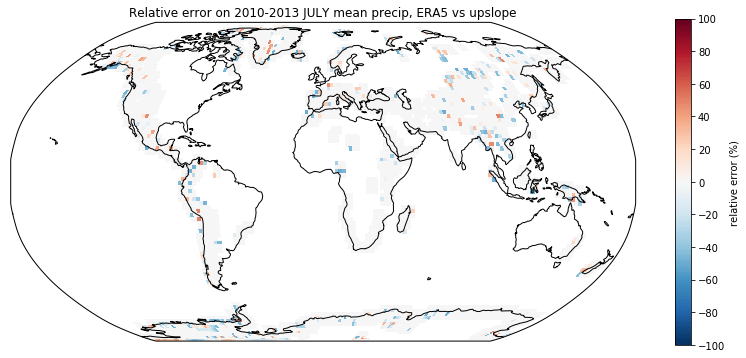

In [32]:
ratio = 100*(PE*pr_omegaupslope_jul2-pr_era5_mean_jul2)/pr_era5_mean_jul2

ratio = ratio*(abs(ratio)<50)

plt.figure(figsize=(14,6));ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
ratio.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"relative error (%)","ticks":np.arange(-100,101,20)},levels=np.linspace(-100.,100.,200))
ax.set_title("Relative error on 2010-2013 JULY mean precip, ERA5 vs upslope")

# CAPE climatology and orographic-convective regions

In [12]:
meancapejan = mean_era5("2010","2013","128_059_cape","01")
meancapejul = mean_era5("2010","2013","128_059_cape","07")

meancapejan_t = 1*(meancapejan>500)
meancapejul_t = 1*(meancapejul>500)

Text(0.5,1,'ERA5 CAPE >500J/kg, 2010-2013 mean,july')

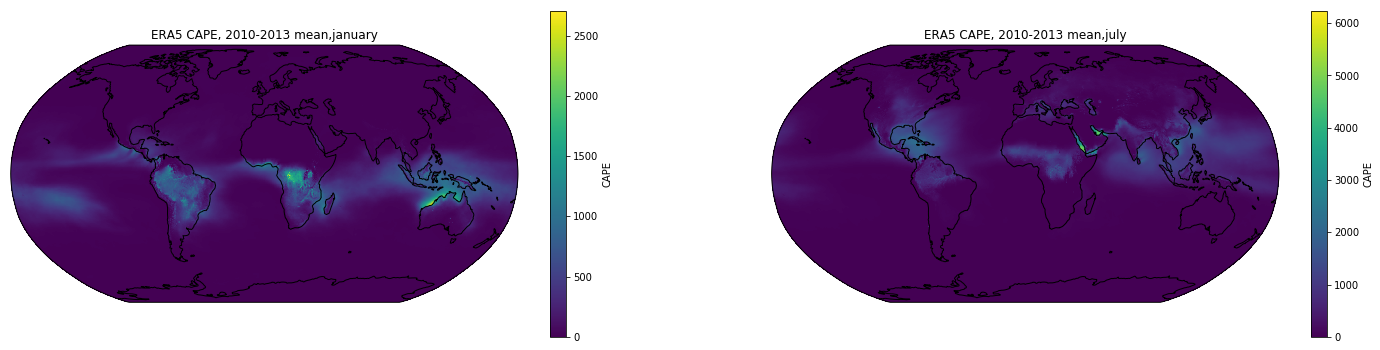

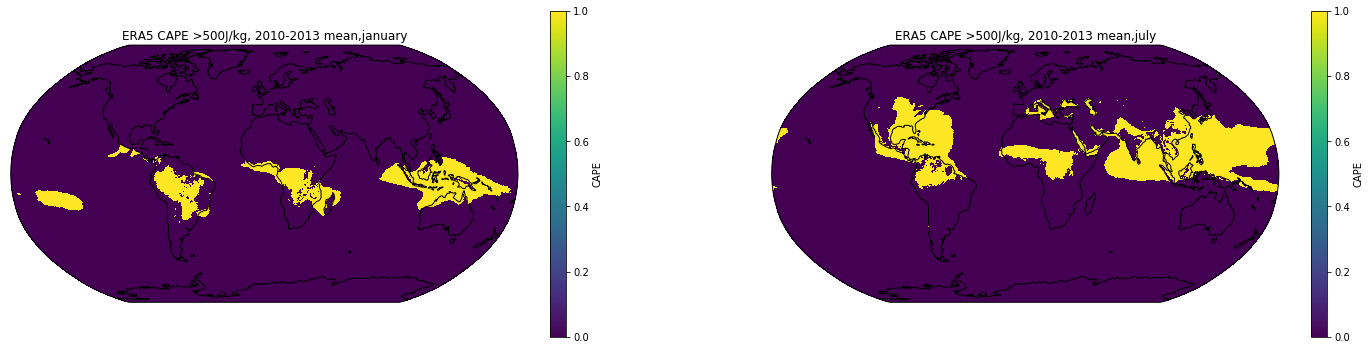

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
meancapejan.plot(ax=ax1,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
meancapejul.plot(ax=ax2,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("ERA5 CAPE, 2010-2013 mean,january");ax2.set_title("ERA5 CAPE, 2010-2013 mean,july")

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
meancapejan_t.plot(ax=ax1,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
meancapejul_t.plot(ax=ax2,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("ERA5 CAPE >500J/kg, 2010-2013 mean,january");ax2.set_title("ERA5 CAPE >500J/kg, 2010-2013 mean,july")




Text(0.5,1,'ERA5 CAPE >500J/kg, 2010-2013 mean,july')

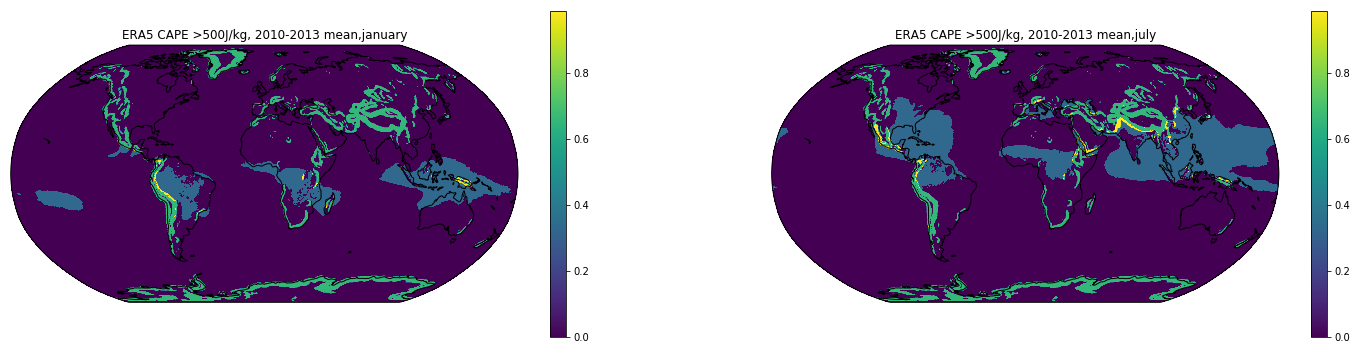

In [15]:
maski = mask.interp_like(meancapejan_t)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
(0.66*maski+0.33*meancapejan_t).plot(ax=ax1,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
(0.66*maski+0.33*meancapejul_t).plot(ax=ax2,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("ERA5 CAPE >500J/kg, 2010-2013 mean,january");ax2.set_title("ERA5 CAPE >500J/kg, 2010-2013 mean,july")



# Precip fraction in orographic regions

## Orog slope mask

In [11]:
def precip_pct(mask,precipmap,globmask=0):
    mask2 = mask.interp_like(precipmap)
    if type(globmask)==int and globmask==0 :
        globmask2=1
    else :
        globmask2 = globmask.interp_like(precipmap)
    return 100*np.array(spatial_mean(mask2*globmask2*precipmap))/np.array(spatial_mean(globmask2*precipmap))

#ERA5 precip
pr_era5_all = 1000*xr.open_dataset("/global/project/projectdirs/m3310/wboos/era5monthly/era5_monthly_slev_1979-2019.nc").tp.sel(time=slice('1979-01-01','2018-12-31'))
pr_era5_mean = pr_era5_all.mean("time")
pr_era5_mean50 = pr_era5_mean.sel(latitude=slice(50., -50.))

#TRMM precip
pr_trmm=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr*3600*24
pr_trmm_mean2 = pr_trmm.mean("time").rename({'lat': 'latitude','lon': 'longitude'})

#ERAI precip
pr_erai_mean=xr.open_dataset("/global/project/projectdirs/m3310/wboos/reanalysis_clean/erai.monthly.PRECIP.nc").PRECIP.mean("time")
pr_erai_mean50=pr_erai_mean.sel(latitude=slice(50., -50.))

#ERA5 landmask
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=landmask.sel(latitude=slice(50., -50.))

continents = {"South America": [270,330,-50,15],
              "North America": [220,310,15,50],
              "Africa": [340,50,-40,37],
              "Maritime continent": [90,160,-10,10],
              "South East Asia": [60,150,10,50]
             }

#orog mask
ddx1=ddxorog_s.isel(time=0)
ddy1=ddyorog_s.isel(time=0)
slopes = np.reshape(np.sqrt(np.array(landmask*(ddx1**2+ddy1**2))),-1)
mask = (1.*(np.sqrt(ddx1**2+ddy1**2)>np.percentile(slopes,90)))
mask50=mask.sel(latitude=slice(50., -50.))
mask250 = 1.*(xr.apply_ufunc(gaussian_filter,mask50,kwargs={"sigma":2.}) > 0)


Text(0.5, 1.0, '2010-2013 mean precip, ERA5, mm/day')

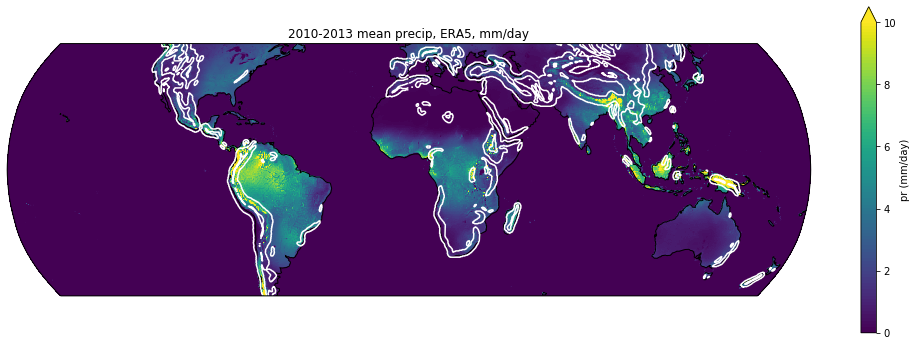

In [12]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
(pr_era5_mean*landmask50).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
mask.sel(latitude=slice(50., -50.)).plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)

#for b in continents.values():
#    ax.add_patch(mpatches.Rectangle(xy=[b[0], b[2]], width=np.mod(b[1]-b[0],360), height=b[3]-b[2],
#                                    edgecolor='r',
#                                    fill = False,
#                                    lw=2,
#                                    transform=ccrs.PlateCarree())
#                 )

ax.set_title("1979-2018 mean precip, ERA5, mm/day")      
         

In [13]:
pr_era5_MEAN = np.array(spatial_mean(pr_era5_mean50))
pr_trmm_MEAN = np.array(spatial_mean(pr_trmm_mean2))
pr_erai_MEAN = np.array(spatial_mean(pr_erai_mean50))
print("Mean pr, ERA5 : %.3f mm/day"%pr_era5_MEAN)
print("Mean pr, TRMM : %.3f mm/day"%pr_trmm_MEAN)
print("Mean pr, ERA-I : %.3f mm/day"%pr_erai_MEAN)
print("")

pr_era5_LANDMEAN = np.array(spatial_mean(pr_era5_mean50*landmask50)                            /spatial_mean(landmask50))                            
pr_trmm_LANDMEAN = np.array(spatial_mean(pr_trmm_mean2 *landmask50.interp_like(pr_trmm_mean2)) /spatial_mean(landmask50)) 
pr_erai_LANDMEAN = np.array(spatial_mean(pr_erai_mean50*landmask50.interp_like(pr_erai_mean50))/spatial_mean(landmask50))
print("Mean pr over land, ERA5 : %.3f mm/day"%pr_era5_LANDMEAN)
print("Mean pr over land, TRMM : %.3f mm/day"%pr_trmm_LANDMEAN)
print("Mean pr over land, ERA-I : %.3f mm/day"%pr_erai_LANDMEAN)
print("")

print("Orographic precip share, ERA5  : %.2f%%"%precip_pct(mask50,pr_era5_mean50))
print("Orographic precip share, TRMM  : %.2f%%"%precip_pct(mask50,pr_trmm_mean2) )
print("Orographic precip share, ERA-I : %.2f%%"%precip_pct(mask50,pr_erai_mean50))
print("")

print("Orographic precip share over land, ERA5  : %.2f%%"%precip_pct(mask50,pr_era5_mean50,landmask50) )
print("Orographic precip share over land, TRMM  : %.2f%%"%precip_pct(mask50,pr_trmm_mean2 ,landmask50) )
print("Orographic precip share over land, ERA-I : %.2f%%"%precip_pct(mask50,pr_erai_mean50,landmask50) )
print("")

for cont,lonlat in continents.items() :
    contmask = 1.*(np.mod(landmask50.longitude,335) > np.mod(lonlat[0],335))*(np.mod(landmask50.longitude,335) < np.mod(lonlat[1],335))*(landmask50.latitude > lonlat[2])*(landmask50.latitude < lonlat[3])
    print("Share of pr over land, ERA5, %s : %.2f%%"%(cont,precip_pct(contmask*(1-mask50),pr_era5_mean50,landmask50)))


print("orog mask area share : %.2f%%"%(100*spatial_mean(mask50)))
print("orog mask area share on land : %.2f%%"%(100*spatial_mean(landmask50*mask50)/spatial_mean(landmask50))) 

#extratropmask = 1*(np.abs(pr_era5_mean50.latitude) > 10.)
#print("Orographic precip share over land, extratropics (small mask), ERA5  : %.2f%%"%precip_pct(mask50,pr_era5_mean50,landmask50*extratropmask))
#print("Orographic precip share over land, extratropics (small mask), TRMM  : %.2f%%"%precip_pct(mask50,pr_trmm_mean2 ,landmask50*extratropmask))
#print("Orographic precip share over land, extratropics (small mask), ERA-I : %.2f%%"%precip_pct(mask50,pr_erai_mean50,landmask50*extratropmask))
#print("small mask area share, extratropics : %.2f%%"%(100*np.array(spatial_mean(mask50*landmask50*extratropmask))/np.array(spatial_mean(landmask50*extratropmask))))



Mean pr, ERA5 : 3.207 mm/day
Mean pr, TRMM : 2.925 mm/day
Mean pr, ERA-I : 3.273 mm/day

Mean pr over land, ERA5 : 2.699 mm/day
Mean pr over land, TRMM : 2.576 mm/day
Mean pr over land, ERA-I : 2.695 mm/day

Orographic precip share, ERA5  : 6.53%
Orographic precip share, TRMM  : 5.90%
Orographic precip share, ERA-I : 5.81%

Orographic precip share over land, ERA5  : 26.65%
Orographic precip share over land, TRMM  : 22.46%
Orographic precip share over land, ERA-I : 24.49%

Share of pr over land, ERA5, South America : 24.26%
Share of pr over land, ERA5, North America : 6.96%
Share of pr over land, ERA5, Africa : 16.64%
Share of pr over land, ERA5, Maritime continent : 6.37%
Share of pr over land, ERA5, South East Asia : 12.04%
orog mask area share : 6.76%
orog mask area share on land : 23.39%


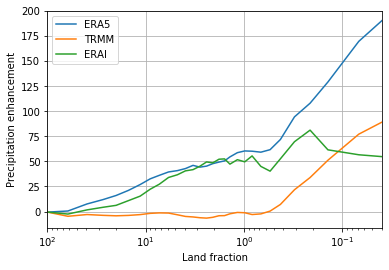

In [56]:
def objfunction_orog(thresh,pr):
    mask = (1.*(np.sqrt(ddx1**2+ddy1**2)>thresh))
    maskt=mask.sel(latitude=slice(50., -50.))
    smls = spatial_mean(landmask50*maskt)/spatial_mean(landmask50)
    a = precip_pct(maskt,pr,landmask50)/100
    return 100*np.array(a/smls-1), 100*smls

def plotpct(pr,lbl,objfunction,ts):
    
    x = np.array([objfunction(*(t ,pr)) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()

ts = np.linspace(1e-4,0.02,30)
plotpct(pr_era5_mean50,"ERA5",objfunction_orog,ts)
plotpct(pr_trmm_mean2 ,"TRMM",objfunction_orog,ts)
plotpct(pr_erai_mean50,"ERAI",objfunction_orog,ts)

plt.xlabel("Land fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()
    

### On the extreme precip

In [54]:
pr_trmm_99th=xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/pr_trmm_99pctile_2010-2013.nc").pr*3600*24
pr_trmm_99th2 = pr_trmm_99th.rename({'lat': 'latitude','lon': 'longitude'})

pr_era5_99th = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/ERA5_IVT_tp_reanalysis_99pctile_2010.nc").tp
pr_era5_99th50 = pr_era5_99th.sel(latitude=slice(50., -50.))



Share of extreme precip in orographic regions, ERA5  : 23.66%
Share of extreme precip in orographic regions, TRMM  : 21.74%

orog mask area share on land : 23.39%


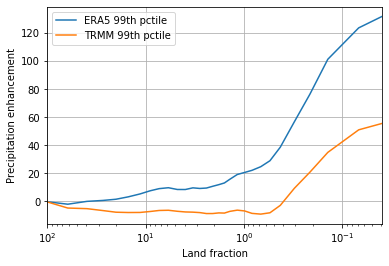

In [57]:
print("Share of extreme precip in orographic regions, ERA5  : %.2f%%"%precip_pct(mask50,pr_era5_99th50,landmask50))
print("Share of extreme precip in orographic regions, TRMM  : %.2f%%"%precip_pct(mask50,pr_trmm_99th2 ,landmask50) )
print("")

print("orog mask area share on land : %.2f%%"%(100*spatial_mean(landmask50*mask50)/spatial_mean(landmask50))) 

ts = np.linspace(1e-4,0.02,30)
plotpct(pr_era5_99th50,"ERA5 99th pctile",objfunction_orog,ts)
plotpct(pr_trmm_99th2 ,"TRMM 99th pctile",objfunction_orog,ts)

plt.xlabel("Land fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()

## Orog + CAPE mask

Text(0.5, 1.0, '2010-2013 mean precip, ERA5, mm/day')

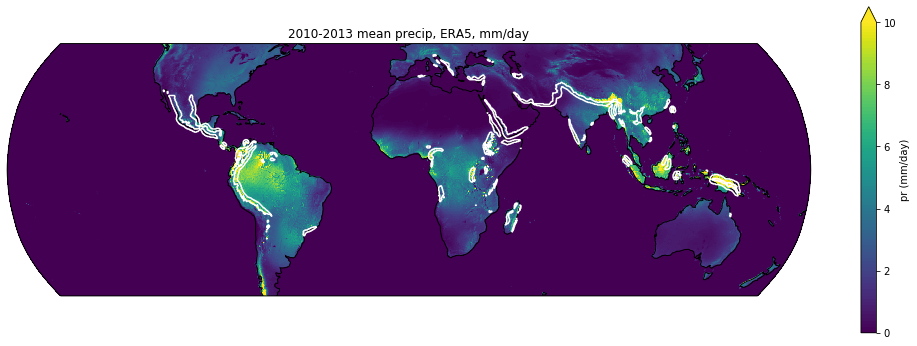

In [58]:
meancape = mean_era5("2010","2013","128_059_cape").interp_like(mask).sel(latitude=slice(50., -50.))
meancape_t = 1*(meancape>250)
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
(pr_era5_mean*landmask50).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
(mask50*meancape_t).plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day")      

In [59]:
print("Orography + CAPE precip share, ERA5 : %.2f%%"%(precip_pct(mask50*meancape_t,pr_era5_mean50,landmask50)))
print("Orography + CAPE precip share, ERA5 : %.2f%%"%(precip_pct(mask50*meancape_t,pr_trmm_mean2,landmask50)))
print("orog + CAPE mask area share on land : %.2f%%"%(100*spatial_mean(landmask50*mask50*meancape_t)/spatial_mean(landmask50))) 

Orography + CAPE precip share, ERA5 : 10.04%
Orography + CAPE precip share, ERA5 : 9.10%
orog + CAPE mask area share on land : 4.55%


Text(0.5, 1.0, 'Precip enhancement in Cape+orog regions compared to cape regions')

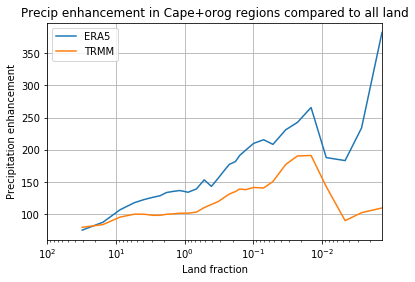

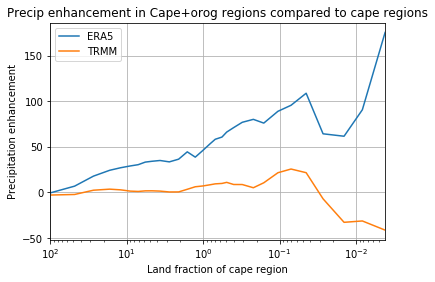

In [60]:
def objfunctioncape(thresh,pr):
    mask = (1.*(np.sqrt(ddx1**2+ddy1**2)>thresh))
    maskt=mask.sel(latitude=slice(50., -50.))*meancape_t
    smls = spatial_mean(landmask50*maskt)/spatial_mean(landmask50)
    a = precip_pct(maskt,pr,landmask50)/100
    return 100*np.array(a/smls-1), 100*smls

def objfunctioncape2(thresh,pr):
    mask = (1.*(np.sqrt(ddx1**2+ddy1**2)>thresh))
    maskt=mask.sel(latitude=slice(50., -50.))*meancape_t
    smls = spatial_mean(landmask50*maskt)/spatial_mean(landmask50*meancape_t)
    a = precip_pct(maskt,pr,landmask50*meancape_t)/100
    return 100*np.array(a/smls-1), 100*smls

ts = np.linspace(1e-4,0.02,30)
plotpct(pr_era5_mean50,"ERA5",objfunctioncape,ts)
plotpct(pr_trmm_mean2 ,"TRMM",objfunctioncape,ts)
plt.xlabel("Land fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()
plt.title("Precip enhancement in Cape+orog regions compared to all land")

plt.figure()
plotpct(pr_era5_mean50,"ERA5",objfunctioncape2,ts)
plotpct(pr_trmm_mean2 ,"TRMM",objfunctioncape2,ts)
plt.xlabel("Land fraction of cape region")
plt.ylabel("Precipitation enhancement")
plt.grid()
plt.title("Precip enhancement in Cape+orog regions compared to cape regions")

## Treshold on the upslope flow

### All-year mean

In [6]:
#u100m_era5_mean = mean_era5("2010","2013",'228_246_100u',mnth="")
#v100m_era5_mean = mean_era5("2010","2013",'228_247_100v',mnth="")

ps_era5_mean = mean_era5("2010","2013",'128_134_sp',mnth="")
u100m_era5_mean = mean_era5("2010","2013",'128_131_u',mnth="").sel(level=ps_era5_mean/100-10,method='nearest')
v100m_era5_mean = mean_era5("2010","2013",'128_132_v',mnth="").sel(level=ps_era5_mean/100-10,method='nearest')
#upslope_w_era5 = (u100m_era5_mean*ddxorog_s.isel(time=0).interp_like(u100m_era5_mean)+
#                  v100m_era5_mean*ddyorog_s.isel(time=0).interp_like(u100m_era5_mean)).fillna(0.)

ddxorog_2 = ddxorog.isel(time=0)
ddyorog_2 = ddyorog.isel(time=0)
upslope_w_era5 = (u100m_era5_mean*ddxorog_2.interp_like(u100m_era5_mean)+
                  v100m_era5_mean*ddyorog_2.interp_like(u100m_era5_mean)).fillna(0.)

dx5 = np.abs(np.array(upslope_w_era5.latitude.isel(latitude=1)-upslope_w_era5.latitude.isel(latitude=0)))
upslope_ws_era5 = xr.apply_ufunc(gaussian_filter,upslope_w_era5,kwargs={"sigma":0.5/dx5})
upslope_w_thresh_era5=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_ws_era5>0.005),
                                   kwargs={"sigma":0.5/dx5})>0.1)

u_erai= xr.open_dataset("/global/project/projectdirs/m3310/wboos/reanalysis_clean/erai.monthly.U.nc").U
ps_erai_mean = xr.open_dataset("/global/project/projectdirs/m3310/wboos/reanalysis_clean/ERAI/ERAI.PS.1979-2015.nc").PS.rename({'lat': 'latitude','lon': 'longitude'}).interp_like(u_erai).mean('time')
u100m_erai_mean = xr.open_dataset("/global/project/projectdirs/m3310/wboos/reanalysis_clean/erai.monthly.U.nc").U.sel(level=ps_erai_mean/100-10,method='nearest').mean("time")
v100m_erai_mean = xr.open_dataset("/global/project/projectdirs/m3310/wboos/reanalysis_clean/erai.monthly.V.nc").V.sel(level=ps_erai_mean/100-10,method='nearest').mean("time")
upslope_w_erai = (u100m_erai_mean*ddxorog_2.interp_like(u100m_erai_mean)+
                  v100m_erai_mean*ddyorog_2.interp_like(u100m_erai_mean)).fillna(0.)

dxi = np.abs(np.array(upslope_w_erai.latitude.isel(latitude=1)-upslope_w_erai.latitude.isel(latitude=0)))
upslope_ws_erai = xr.apply_ufunc(gaussian_filter,upslope_w_erai,kwargs={"sigma":0.5/dxi})
upslope_w_thresh_erai=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_ws_erai>0.005),
                                   kwargs={"sigma":0.5/dxi})>0.1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, '1979-2018 mean precip, ERA5, mm/day')

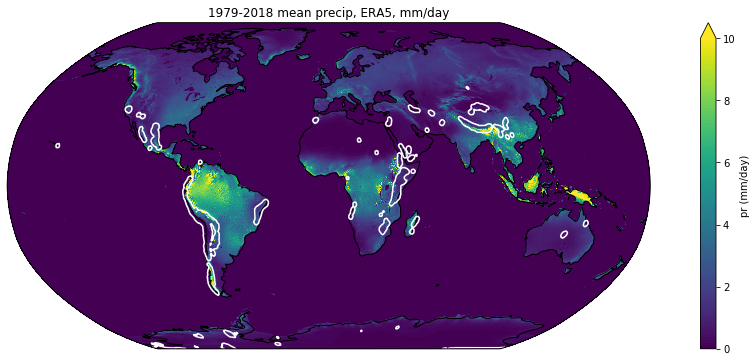

In [31]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_era5_mean*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_era5.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day")      

Text(0.5, 1.0, '1979-2018 mean precip, ERA5, mm/day')

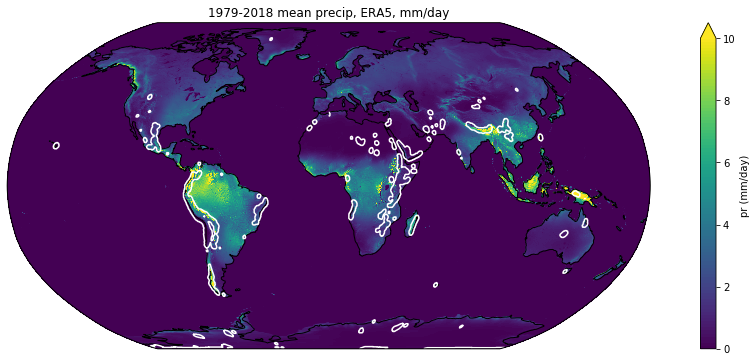

In [58]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_era5_mean*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_era5.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day")      

Text(0.5, 1.0, '1979-2018 mean precip, ERA5, mm/day')

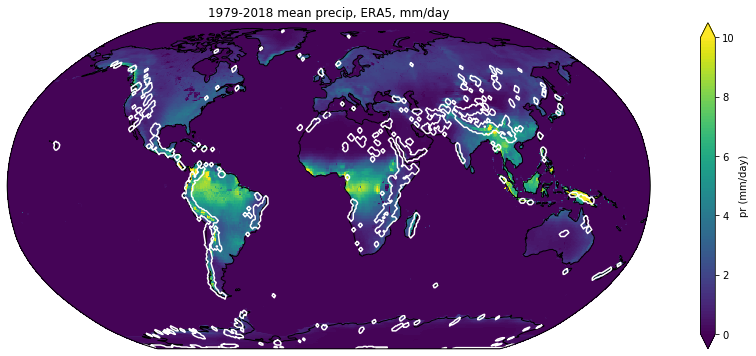

In [59]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_erai_mean*landmask.interp_like(pr_erai_mean)).plot(ax=ax,transform=ccrs.PlateCarree(),cmap = plt.cm.viridis,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_erai.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day")      

In [22]:

era5share = precip_pct(upslope_w_thresh_era5,pr_era5_mean,landmask); print("Orographic precip share over land (small mask), ERA5  : %.2f%%"%era5share)
era5landshare = 100*spatial_mean(landmask*upslope_w_thresh_era5.interp_like(landmask))/spatial_mean(landmask); print("upslope mask land share,ERA5 : %.2f%%"%era5landshare)
print("enhancement : %.2f%%"%((era5share/era5landshare-1)*100))
eraishare = precip_pct(upslope_w_thresh_erai,pr_erai_mean,landmask); print("Orographic precip share over land (small mask), ERAI  : %.2f%%"%eraishare)
erailandshare = 100*spatial_mean(landmask*upslope_w_thresh_erai.interp_like(landmask))/spatial_mean(landmask); print("upslope mask land share,ERA5 : %.2f%%"%erailandshare)
print("enhancement : %.2f%%"%((eraishare/erailandshare-1)*100))




Orographic precip share over land (small mask), ERA5  : 7.07%
upslope mask land share,ERA5 : 5.68%
enhancement : 24.53%
Orographic precip share over land (small mask), ERAI  : 8.49%
upslope mask land share,ERA5 : 6.80%
enhancement : 24.92%


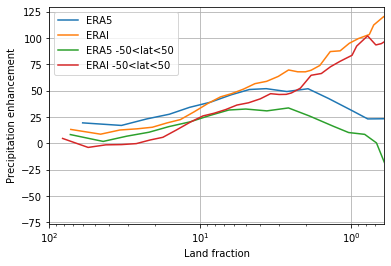

In [61]:
def objfunction_upslope(thresh,pr,upslope_w,dx,latlim=90.):
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(upslope_w>thresh),kwargs={"sigma":0.5/dx})>0.1)
    maskt=mask.interp_like(landmask).sel(latitude=slice(latlim, -latlim))
    landmasklim = landmask.sel(latitude=slice(latlim, -latlim))
    smls = spatial_mean(landmasklim*maskt)/spatial_mean(landmasklim)
    a = precip_pct(maskt,pr,landmasklim)/100
    return 100*np.array(a/smls-1), 100*smls

def plotpct(pr,upslope_w,dx,lbl,latlim=90.):
    ts = np.linspace(0.,0.025,30)
    x = np.array([objfunction_upslope(t ,pr,upslope_w,dx,latlim) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()
    
plotpct(pr_era5_mean,upslope_ws_era5,dx5,"ERA5")
plotpct(pr_erai_mean,upslope_ws_erai,dxi,"ERAI")
    
plotpct(pr_era5_mean50,upslope_ws_era5,dx5,"ERA5 -50<lat<50",50.)
plotpct(pr_erai_mean50,upslope_ws_erai,dxi,"ERAI -50<lat<50",50.)

plt.xlabel("Land fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()
    

### By season

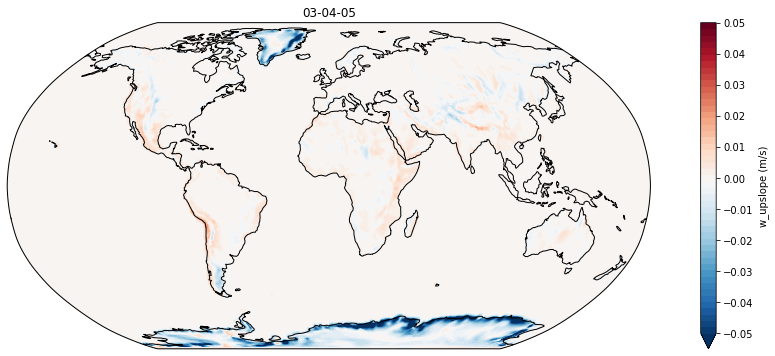

In [24]:
def plotmean(m1,m2,m3):
    u100m_era5_m123mean = (mean_era5("2010","2013",'228_246_100u',mnth=m1)
                          +mean_era5("2010","2013",'228_246_100u',mnth=m2)
                          +mean_era5("2010","2013",'228_246_100u',mnth=m3)
                        )/3.
    v100m_era5_m123mean = (mean_era5("2010","2013",'228_247_100v',mnth=m1)
                          +mean_era5("2010","2013",'228_247_100v',mnth=m2)
                          +mean_era5("2010","2013",'228_247_100v',mnth=m3)
                        )/3.
    upslope_w_era5_m123 = (u100m_era5_m123mean*ddxorog_s.isel(time=0).interp_like(u100m_era5_m123mean)+
                          v100m_era5_m123mean*ddyorog_s.isel(time=0).interp_like(u100m_era5_m123mean)).fillna(0.)
    
    dx5 = np.abs(np.array(upslope_w_era5_m123.latitude.isel(latitude=1)-upslope_w_era5_m123.latitude.isel(latitude=0)))
    upslope_ws_era5_m123 = xr.apply_ufunc(gaussian_filter,upslope_w_era5_m123,kwargs={"sigma":0.5/dx5})
    
    plt.figure(figsize=(18,6))
    ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
    upslope_ws_era5_m123.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"w_upslope (m/s)","ticks":np.arange(-0.05,0.051,0.01)},levels=np.linspace(-0.05,0.05,50))
    plt.title("-".join([m1,m2,m3]))
plotmean("03","04","05")

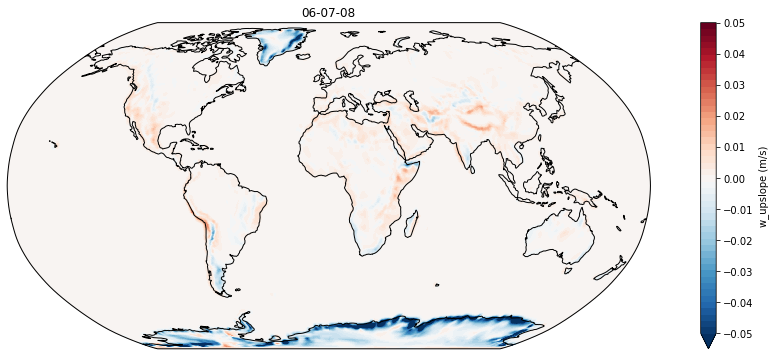

In [25]:
plotmean("06","07","08")

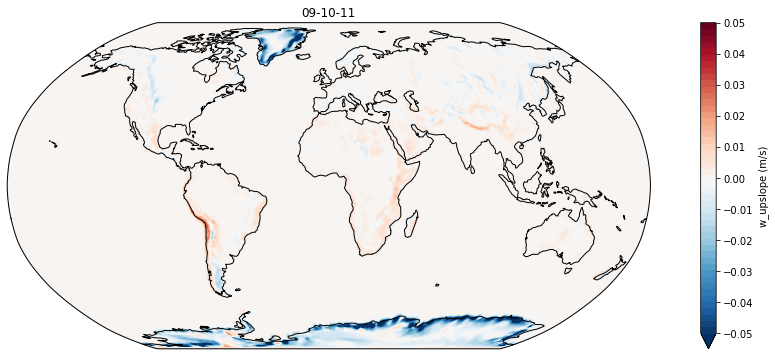

In [26]:
plotmean("09","10","11")

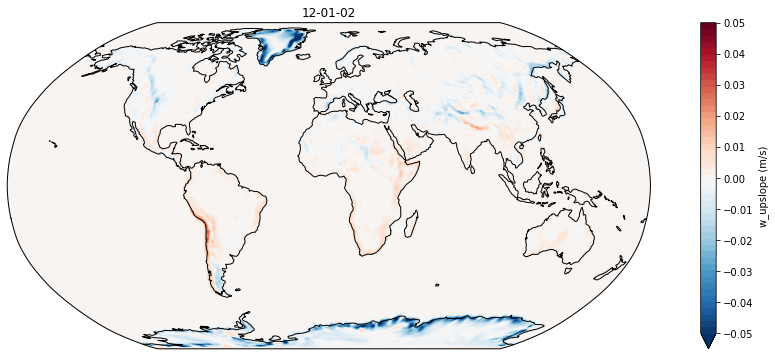

In [27]:
plotmean("12","01","02")

In [6]:
def upslope_thresh(m1,m2,m3):
    u100m_era5_m123mean = (mean_era5("2010","2013",'228_246_100u',mnth=m1)
                         +mean_era5("2010","2013",'228_246_100u',mnth=m2)
                         +mean_era5("2010","2013",'228_246_100u',mnth=m3)
                        )/3.
    v100m_era5_m123mean = (mean_era5("2010","2013",'228_247_100v',mnth=m1)
                         +mean_era5("2010","2013",'228_247_100v',mnth=m2)
                         +mean_era5("2010","2013",'228_247_100v',mnth=m3)
                      )/3.
    upslope_w_era5_m123 = (u100m_era5_m123mean*ddxorog_s.isel(time=0).interp_like(u100m_era5_m123mean)+
                      v100m_era5_m123mean*ddyorog_s.isel(time=0).interp_like(u100m_era5_m123mean)).fillna(0.)
    
    dx5 = np.abs(np.array(upslope_w_era5_m123.latitude.isel(latitude=1)-upslope_w_era5_m123.latitude.isel(latitude=0)))
    upslope_ws_era5_m123 = xr.apply_ufunc(gaussian_filter,upslope_w_era5_m123,kwargs={"sigma":0.5/dx5})
    upslope_w_thresh_era5_m123=1*(xr.apply_ufunc(gaussian_filter,
                                       1.*(upslope_ws_era5_m123>0.005),
                                       kwargs={"sigma":0.5/dx5})>0.1)
    return upslope_ws_era5_m123,upslope_w_thresh_era5_m123

upslope_ws_era5_DJF, upslope_w_thresh_era5_DJF = upslope_thresh("12","01","02")
upslope_ws_era5_MAM, upslope_w_thresh_era5_MAM = upslope_thresh("03","04","05")
upslope_ws_era5_JJA, upslope_w_thresh_era5_JJA = upslope_thresh("06","07","08")
upslope_ws_era5_SON, upslope_w_thresh_era5_SON = upslope_thresh("09","10","11")

Text(0.5, 1.0, '2010-2013 JJA mean precip, ERA5, mm/day')

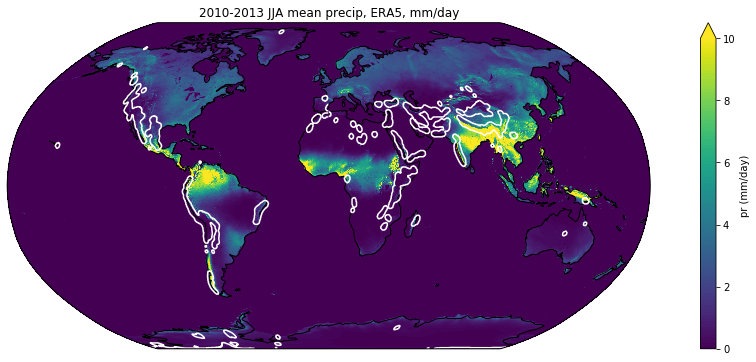

In [29]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_era5_mean_JJA*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_era5_JJA.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 JJA mean precip, ERA5, mm/day")      

Text(0.5, 1.0, '2010-2013 DJF mean precip, ERA5, mm/day')

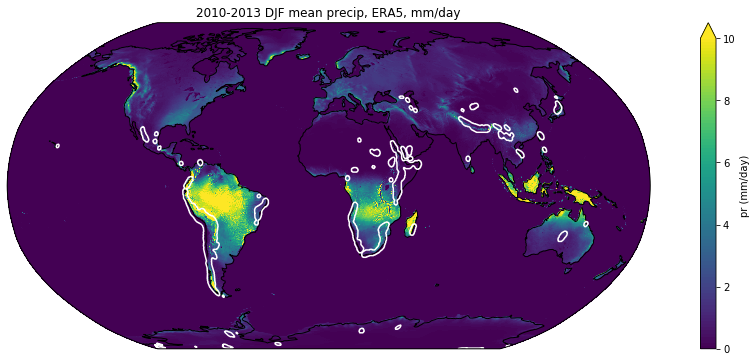

In [30]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
(pr_era5_mean_DJF*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_era5_DJF.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 DJF mean precip, ERA5, mm/day")      

Text(0.5, 1.0, '2010-2013 MAM mean precip, ERA5, mm/day')

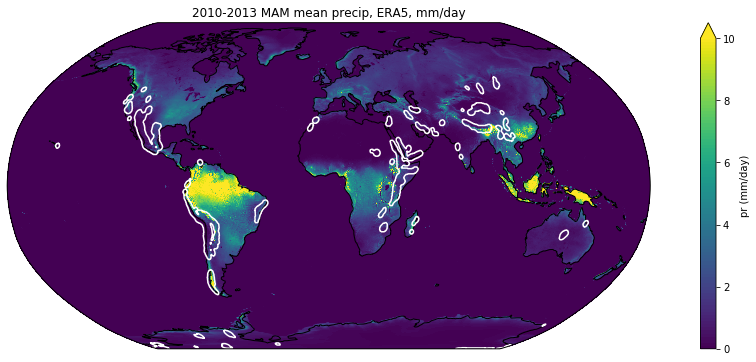

In [31]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
(pr_era5_mean_MAM*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_era5_MAM.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 MAM mean precip, ERA5, mm/day")      

Text(0.5, 1.0, '1979-2018 SON mean precip, ERA5, mm/day')

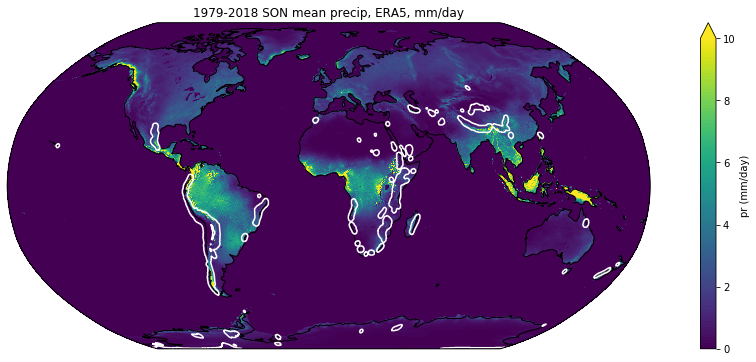

In [10]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
(pr_era5_mean_SON*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_w_thresh_era5_SON.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 SON mean precip, ERA5, mm/day")      

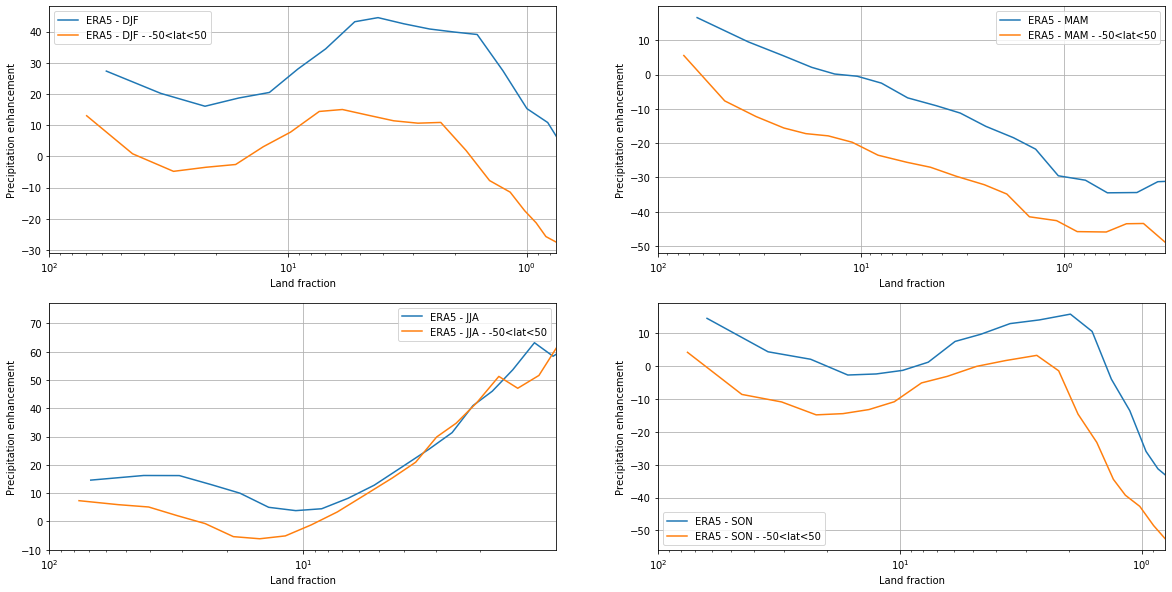

In [66]:
def objfunction_upslope(thresh,pr,upslope_w,dx,latlim=90.):
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(upslope_w>thresh),kwargs={"sigma":0.5/dx})>0.1)
    maskt=mask.interp_like(landmask).sel(latitude=slice(latlim,-latlim))#.sel(latitude=slice(0., -latlim))
    landmasklim = landmask.sel(latitude=slice(latlim,-latlim))#.sel(latitude=slice(0., -latlim))
    smls = spatial_mean(landmasklim*maskt)/spatial_mean(landmasklim)
    a = precip_pct(maskt,pr,landmasklim)/100
    return 100*np.array(a/smls-1), 100*smls

def plotpct(ax,pr,upslope_w,dx,lbl,latlim=90.):
    ts = np.linspace(0.,0.015,20)
    x = np.array([objfunction_upslope(t ,pr,upslope_w,dx,latlim) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    ax.plot(smlss,pcts,label=lbl)
    ax.set_xscale('log')
    ax.set_xlim(100,min(smlss))

    ax.legend()
    ax.set_xlabel("Land fraction")
    ax.set_ylabel("Precipitation enhancement")
    ax.grid()

_,axs = plt.subplots(2,2,figsize=(20,10))
plotpct(axs[1,0],pr_era5_mean_JJA,upslope_ws_era5_JJA,dx5,"ERA5 - JJA")
plotpct(axs[0,0],pr_era5_mean_DJF,upslope_ws_era5_DJF,dx5,"ERA5 - DJF")
plotpct(axs[0,1],pr_era5_mean_MAM,upslope_ws_era5_MAM,dx5,"ERA5 - MAM")
plotpct(axs[1,1],pr_era5_mean_SON,upslope_ws_era5_SON,dx5,"ERA5 - SON")

plotpct(axs[1,0],pr_era5_mean_JJA,upslope_ws_era5_JJA,dx5,"ERA5 - JJA - -50<lat<50",50.)
plotpct(axs[0,0],pr_era5_mean_DJF,upslope_ws_era5_DJF,dx5,"ERA5 - DJF - -50<lat<50",50.)
plotpct(axs[0,1],pr_era5_mean_MAM,upslope_ws_era5_MAM,dx5,"ERA5 - MAM - -50<lat<50",50.)
plotpct(axs[1,1],pr_era5_mean_SON,upslope_ws_era5_SON,dx5,"ERA5 - SON - -50<lat<50",50.)
axs[1,0].grid()
axs[0,0].grid()
axs[0,1].grid()
axs[1,1].grid()



### CESM

In [42]:
u_cesm = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/ua/gn/v20190308/ua_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc").ua
v_cesm = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/va/gn/v20190308/va_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc").va
ps_cesm = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/ps/gn/v20190308/ps_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc").ps

ps_cesm_mean = ps_cesm.sel(time=slice("1979-01-01","2014-12-31")).mean("time")

u_cesm_mean = u_cesm.sel(time=slice("1979-01-01","2014-12-31")).mean("time").fillna(0.)
v_cesm_mean = v_cesm.sel(time=slice("1979-01-01","2014-12-31")).mean("time").fillna(0.)

u100m_cesm_mean = u_cesm_mean.sel(plev=ps_cesm_mean-1000.,method='bfill').rename({'lat': 'latitude','lon': 'longitude'})
v100m_cesm_mean = v_cesm_mean.sel(plev=ps_cesm_mean-1000.,method='bfill').rename({'lat': 'latitude','lon': 'longitude'})


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ua' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'va' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ps' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [43]:
orog_cesm = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/fx/orog/gn/v20190308/orog_fx_CESM2_historical_r1i1p1f1_gn.nc").orog.rename({'lat': 'latitude','lon': 'longitude'}) 

m_per_degreelat = 6370*1e3*np.pi/180
coslat = np.cos(orog_cesm.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))
ddxorog_cesm = orog_cesm.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog_cesm = orog_cesm.differentiate("latitude")/m_per_degreelat

upslope_w_cesm = u100m_cesm_mean*ddxorog_cesm+v100m_cesm_mean*ddyorog_cesm


dx = np.abs(np.array(upslope_w_cesm.latitude.isel(latitude=1)-upslope_w_cesm.latitude.isel(latitude=0)))
upslope_ws_cesm = xr.apply_ufunc(gaussian_filter,upslope_w_cesm,kwargs={"sigma":0.5/dx})
upslope_w_thresh_cesm=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_ws_cesm>0.01),
                                   kwargs={"sigma":0.5/dx})>0.1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'orog' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Text(0.5, 1.0, 'Mask obtained after smoothing')

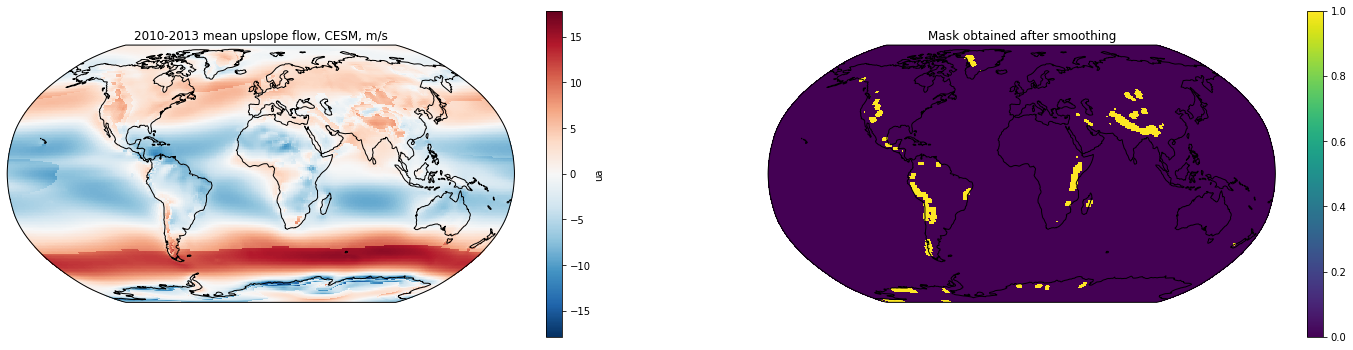

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.Robinson()})
u100m_cesm_mean.plot(      ax=ax1,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"w_upslope (m/s)","ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(-0.02,0.02,100))
upslope_w_thresh_cesm.plot(ax=ax2,transform=ccrs.PlateCarree())#,cbar_kwargs={"label":"CAPE (J/kg)","ticks":np.arange(0.,21.,4.)},levels=np.linspace(0.,20.,100))
ax1.coastlines();ax2.coastlines()
ax1.set_title("2010-2013 mean upslope flow, CESM, m/s");ax2.set_title("Mask obtained after smoothing")

In [45]:
pr_cesm_mean = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/pr/gn/v20190401/pr_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc").pr.sel(time=slice("1979-01-01","2014-12-31")).mean("time").rename({'lat': 'latitude','lon': 'longitude'})

pr_cesm_MEAN = np.array(spatial_mean(pr_cesm_mean))
pr_cesm_LANDMEAN = np.array(spatial_mean(pr_cesm_mean*landmask.interp_like(pr_cesm_mean))/spatial_mean(landmask50.interp_like(pr_cesm_mean)))          
print("Mean pr, ERA5 : %.3f mm/day"%pr_cesm_MEAN)   
print("Mean pr over land, ERA5 : %.3f mm/day"%pr_cesm_LANDMEAN)

print("Orographic precip share (small mask), CESM  : %.2f%%"%precip_pct(upslope_w_thresh_cesm,pr_cesm_mean))
print("upslope mask global share, CESM : %.2f%%"%(100*spatial_mean(upslope_w_thresh_cesm)))

print("Orographic precip share over land (small mask), CESM  : %.2f%%"%precip_pct(upslope_w_thresh_cesm,pr_cesm_mean,landmask))
print("upslope mask land share,CESM : %.2f%%"%(100*spatial_mean(landmask*upslope_w_thresh_cesm.interp_like(landmask))/spatial_mean(landmask)))


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Mean pr, ERA5 : 0.000 mm/day
Mean pr over land, ERA5 : 0.000 mm/day
Orographic precip share (small mask), CESM  : 2.14%
upslope mask global share, CESM : 1.93%
Orographic precip share over land (small mask), CESM  : 8.83%
upslope mask land share,CESM : 6.25%


In [46]:
86400*pr_cesm_mean.mean(["latitude","longitude"])

<xarray.DataArray 'pr' ()>
array(2.41690407)

## Treshold on $q_{925}~u_{100m}\cdot\nabla z$ 

In [15]:
q925_era5_mean = mean_era5("2010","2013",'128_133_q',mnth="").sel(level=925.)
upslope_qw_era5 = q925_era5_mean.interp_like(upslope_w_era5)*upslope_w_era5

upslope_qws_era5 = xr.apply_ufunc(gaussian_filter,upslope_qw_era5,kwargs={"sigma":0.5/dx5})
upslope_qw_thresh_era5=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_qws_era5>4e-5),
                                   kwargs={"sigma":0.5/dx5})>0.1)

q925_erai_mean = xr.open_dataset("/global/cscratch1/sd/qnicolas/ERAI/ei.moda.an.pl.regn128sc.Q.1979-2016.nc").Q_GDS4_ISBL_123.rename({'g4_lat_1':'latitude','g4_lon_2':'longitude','lv_ISBL0':'level'}).sel(level=925.).mean('time')
upslope_qw_erai = q925_erai_mean.interp_like(upslope_w_erai)*upslope_w_erai

upslope_qws_erai = xr.apply_ufunc(gaussian_filter,upslope_qw_erai,kwargs={"sigma":0.5/dxi})
upslope_qw_thresh_erai=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_qws_erai>5e-5),
                                   kwargs={"sigma":0.5/dxi})>0.1)

Text(0.5, 1.0, '1979-2015 mean precip, ERAI, mm/day, land share = 10.0%')

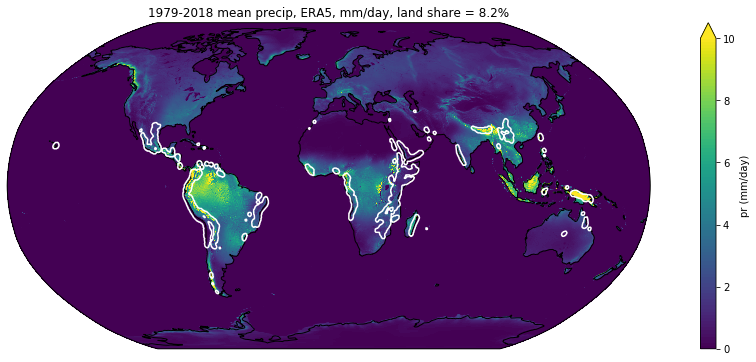

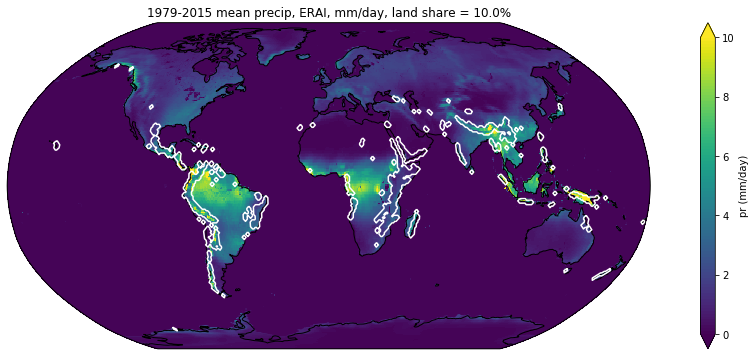

In [16]:
plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_era5_mean*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_qw_thresh_era5.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day, land share = %.1f%%"%(100*spatial_mean(landmask.interp_like(upslope_qw_thresh_era5)*upslope_qw_thresh_era5)/spatial_mean(landmask)))      

plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_erai_mean*landmask.interp_like(pr_erai_mean)).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=plt.cm.viridis,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_qw_thresh_erai.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2015 mean precip, ERAI, mm/day, land share = %.1f%%"%(100*spatial_mean(landmask.interp_like(upslope_qw_thresh_erai)*upslope_qw_thresh_erai)/spatial_mean(landmask.interp_like(upslope_qw_thresh_erai))))    


Text(0.5, 1.0, '1979-2015 mean precip, ERAI, mm/day, land share = 3.9%')

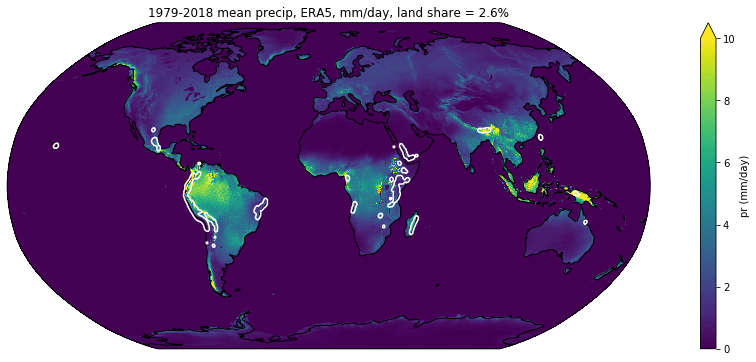

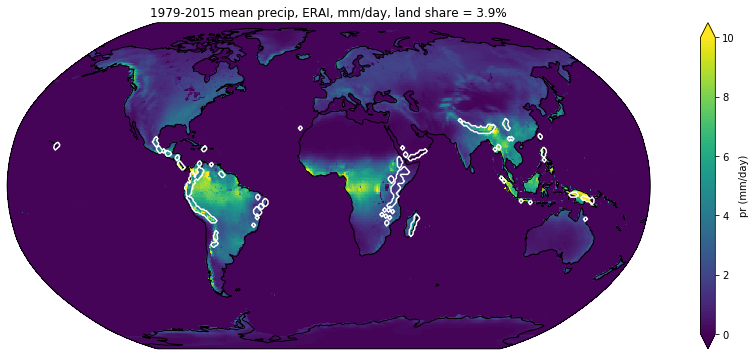

In [17]:
upslope_qw_thresh_era5_2=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_qws_era5>8e-5),
                                   kwargs={"sigma":0.5/dx5})>0.1)

upslope_qw_thresh_erai_2=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_qws_erai>1e-4),
                                   kwargs={"sigma":0.5/dxi})>0.1)

plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_era5_mean*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_qw_thresh_era5_2.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day, land share = %.1f%%"%(100*spatial_mean(landmask.interp_like(upslope_qw_thresh_era5_2)*upslope_qw_thresh_era5_2)/spatial_mean(landmask)))      

plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_erai_mean*landmask.interp_like(pr_erai_mean)).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=plt.cm.viridis,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_qw_thresh_erai_2.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2015 mean precip, ERAI, mm/day, land share = %.1f%%"%(100*spatial_mean(landmask.interp_like(upslope_qw_thresh_erai_2)*upslope_qw_thresh_erai_2)/spatial_mean(landmask.interp_like(upslope_qw_thresh_erai_2))))    


Text(0.5, 1.0, 'q_925 * upslope flow mask')

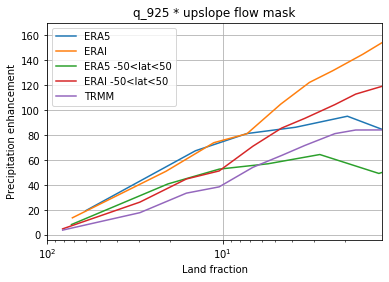

In [32]:
def objfunction_upslope(thresh,pr,upslope_w,dx,latlim=90.):
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(upslope_w>thresh),kwargs={"sigma":0.5/dx})>0.1)
    maskt=mask.interp_like(landmask).sel(latitude=slice(latlim, -latlim))
    landmasklim = landmask.sel(latitude=slice(latlim, -latlim))
    smls = spatial_mean(landmasklim*maskt)/spatial_mean(landmasklim)
    a = precip_pct(maskt,pr,landmasklim)/100
    return 100*np.array(a/smls-1), 100*smls

def plotpct(pr,upslope_w,dx,lbl,latlim=90.):
    ts = np.linspace(0.,2e-4,10)
    x = np.array([objfunction_upslope(t ,pr,upslope_w,dx,latlim) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()

plotpct(pr_era5_mean,upslope_qws_era5,dx5,"ERA5")
plotpct(pr_erai_mean,upslope_qws_erai,dxi,"ERAI")
    
plotpct(pr_era5_mean50,upslope_qws_era5,dx5,"ERA5 -50<lat<50",50.)
plotpct(pr_erai_mean50,upslope_qws_erai,dxi,"ERAI -50<lat<50",50.)

plotpct(pr_trmm_mean2,upslope_qws_erai,dxi,"TRMM",50.)

plt.xlabel("Land fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()
plt.title("q_925 * upslope flow mask")

### precipitable water * $u_{100m}\cdot\nabla z$ 

In [9]:
pw_era5_mean = mean_era5("2010","2013",'128_137_tcwv',mnth="")
upslope_qw_era5_2 = pw_era5_mean.interp_like(upslope_w_era5)*upslope_w_era5
upslope_qws_era5_2 = xr.apply_ufunc(gaussian_filter,upslope_qw_era5_2,kwargs={"sigma":0.5/dx5})

pw_erai_mean = xr.open_dataset("/global/project/projectdirs/m3310/wboos/reanalysis_clean/ERAI/ERAI.Q.1979-2015.nc").Q.rename({'lat':'latitude','lon':'longitude'}).mean('time')
upslope_qw_erai_2 = pw_erai_mean.interp_like(upslope_w_erai)*upslope_w_erai
upslope_qws_erai_2 = xr.apply_ufunc(gaussian_filter,upslope_qw_erai_2,kwargs={"sigma":0.5/dxi})


Text(0.5, 1.0, '1979-2018 mean precip, ERA5, mm/day || PW mask, land share = 9.0%')

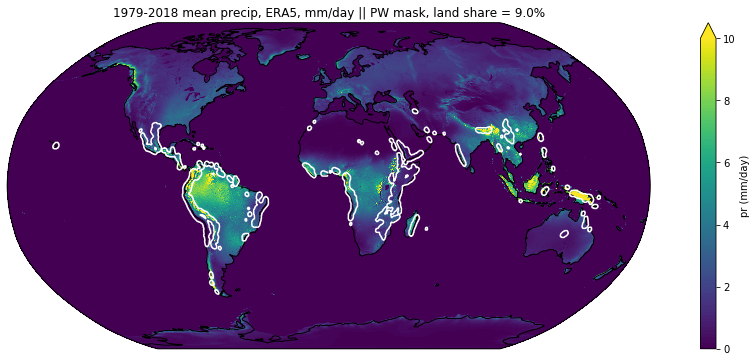

In [35]:
upslope_qw_thresh_era5_2=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_qws_era5_2>0.1),
                                   kwargs={"sigma":0.5/dx5})>0.1)

plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
(pr_era5_mean*landmask).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,11.,2.)},levels=np.linspace(0.,10.,100))
kw = {'levels':[0.5], 'colors':['w']}
upslope_qw_thresh_era5_2.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.set_title("1979-2018 mean precip, ERA5, mm/day || PW mask, land share = %.1f%%"%(100*spatial_mean(landmask.interp_like(upslope_qw_thresh_era5_2)*upslope_qw_thresh_era5_2)/spatial_mean(landmask)))      


Text(0.5, 1.0, 'Precipitable water * upslope flow mask')

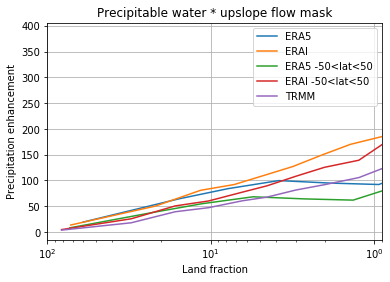

In [31]:
def plotpct(pr,upslope_w,dx,lbl,latlim=90.):
    ts = np.linspace(0.,5e-1,10)
    x = np.array([objfunction_upslope(t ,pr,upslope_w,dx,latlim) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()

plotpct(pr_era5_mean,upslope_qws_era5_2,dx5,"ERA5")
plotpct(pr_erai_mean,upslope_qws_erai_2,dxi,"ERAI")
    
plotpct(pr_era5_mean50,upslope_qws_era5_2,dx5,"ERA5 -50<lat<50",50.)
plotpct(pr_erai_mean50,upslope_qws_erai_2,dxi,"ERAI -50<lat<50",50.)

plotpct(pr_trmm_mean2,upslope_qws_erai_2,dxi,"TRMM",50.)

plt.xlabel("Land fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()
plt.title("Precipitable water * upslope flow mask")

### Including ocean ?

In [7]:
pr_trmm_mean07 = pr_trmm.sel(time=(pr_trmm['time.month']==7)).mean('time').rename({'lat': 'latitude','lon': 'longitude'})

In [8]:
pw_era5_mean07 = mean_era5("2010","2013",'128_137_tcwv',mnth="")
#q925_era5_mean07 = mean_era5("2010","2013",'128_133_q',mnth="07").sel(level=925.)

u100m_era5_mean07 = mean_era5("2010","2013",'228_246_100u',mnth="07")
v100m_era5_mean07 = mean_era5("2010","2013",'228_247_100v',mnth="07")
upslope_w_era5_07 = (u100m_era5_mean07*ddxorog_2.interp_like(u100m_era5_mean07)+
                  v100m_era5_mean07*ddyorog_2.interp_like(u100m_era5_mean07)).fillna(0.)

upslope_qw_era5_07 = pw_era5_mean07.interp_like(upslope_w_era5_07)*upslope_w_era5_07
upslope_qws_era5_07 = xr.apply_ufunc(gaussian_filter,upslope_qw_era5_07,kwargs={"sigma":0.5/dx5})
upslope_qw_thresh_era5_07=1*(xr.apply_ufunc(gaussian_filter,
                                   1.*(upslope_qws_era5_07>0.1),
                                   kwargs={"sigma":0.5/dx5})>0.1)


Area fraction : 5.6%


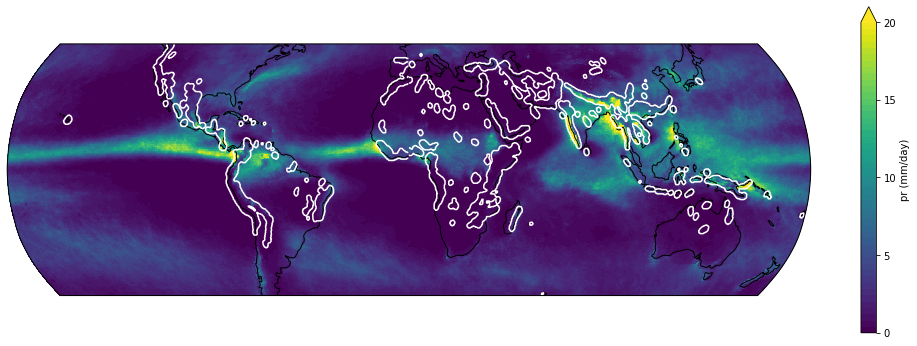

In [44]:
m=20.
plt.figure(figsize=(18,6));ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
pr_trmm_mean07.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
kw = {'levels':[0.5], 'colors':['w']}
upslope_qw_thresh_era5_07.sel(latitude=slice(50.,-50.)).plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
print("Area fraction : %.1f%%"%(100*spatial_mean(upslope_qw_thresh_era5_07)))

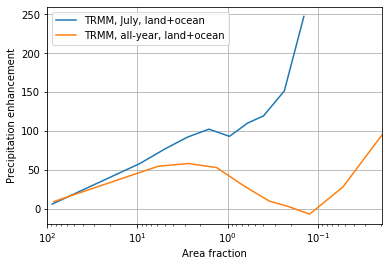

In [12]:
def objfunction_upslope(thresh,pr,upslope_w,dx):
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(upslope_w>thresh),kwargs={"sigma":0.5/dx})>0.1)
    sms = spatial_mean(mask)
    a = precip_pct(mask,pr)/100
    return 100*np.array(a/sms-1), 100*sms

def plotpct(pr,upslope_w,dx,lbl):
    ts = np.linspace(0.,0.5,10)
    x = np.array([objfunction_upslope(t ,pr,upslope_w,dx) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()

plotpct(pr_trmm_mean07,upslope_qws_era5_07,dx5,"TRMM, July, land+ocean")
plotpct(pr_trmm_mean2,upslope_qws_era5_2,dx5,"TRMM, all-year, land+ocean")

plt.xlabel("Area fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()

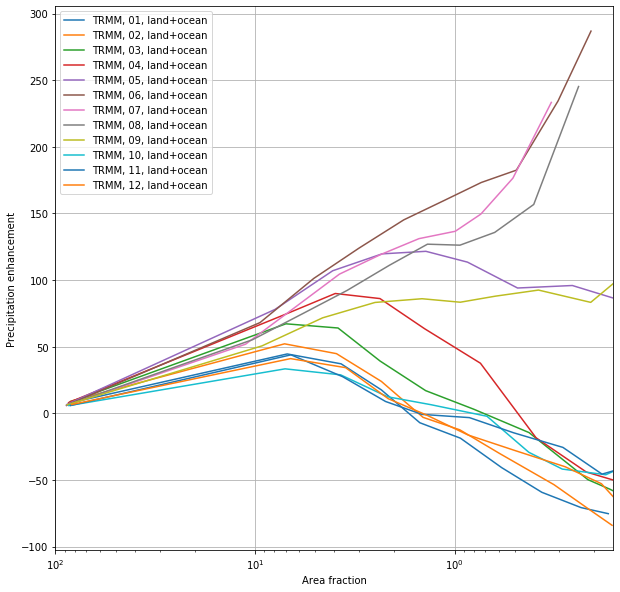

In [47]:
def objfunction_upslope(thresh,pr,upslope_w,dx):
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(upslope_w>thresh),kwargs={"sigma":0.5/dx})>0.1)
    sms = spatial_mean(mask)
    a = precip_pct(mask,pr)/100
    return 100*np.array(a/sms-1), 100*sms

def plotpct(pr,upslope_w,dx,lbl):
    ts = np.linspace(0.,0.5,10)
    x = np.array([objfunction_upslope(t ,pr,upslope_w,dx) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()

plt.figure(figsize=(10,10))
for m in ["{:02}".format(i) for i in range(1,13)]:
    #q925_era5_meanm = mean_era5("2010","2013",'128_133_q',mnth=m).sel(level=925.)
    pw_era5_meanm = mean_era5("2010","2013",'128_137_tcwv',mnth=m)

    u100m_era5_meanm = mean_era5("2010","2013",'228_246_100u',mnth=m)
    v100m_era5_meanm = mean_era5("2010","2013",'228_247_100v',mnth=m)

    upslope_w_era5_m = (u100m_era5_meanm*ddxorog_2.interp_like(u100m_era5_meanm)+
                      v100m_era5_meanm*ddyorog_2.interp_like(u100m_era5_meanm)).fillna(0.)
    
    upslope_qw_era5_m = pw_era5_meanm.interp_like(upslope_w_era5_m)*upslope_w_era5_m
    upslope_qws_era5_m = xr.apply_ufunc(gaussian_filter,upslope_qw_era5_m,kwargs={"sigma":0.5/dx5})

    pr_trmm_meanm = pr_trmm.sel(time=(pr_trmm['time.month']==7)).mean('time').rename({'lat': 'latitude','lon': 'longitude'})
    plotpct(pr_trmm_meanm,upslope_qws_era5_m,dx5,"TRMM, %s, land+ocean"%m)

plt.xlabel("Area fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()

# Climatology per box with Smith's model

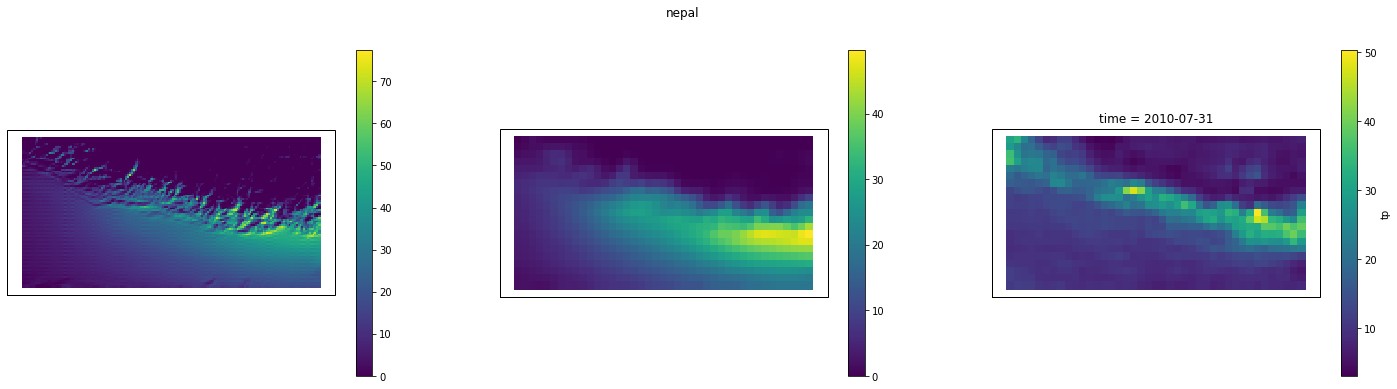

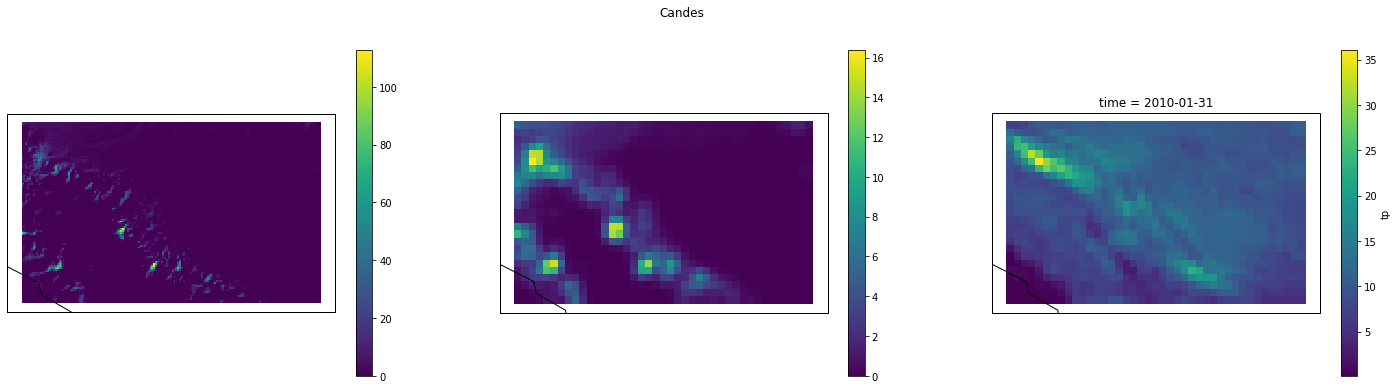

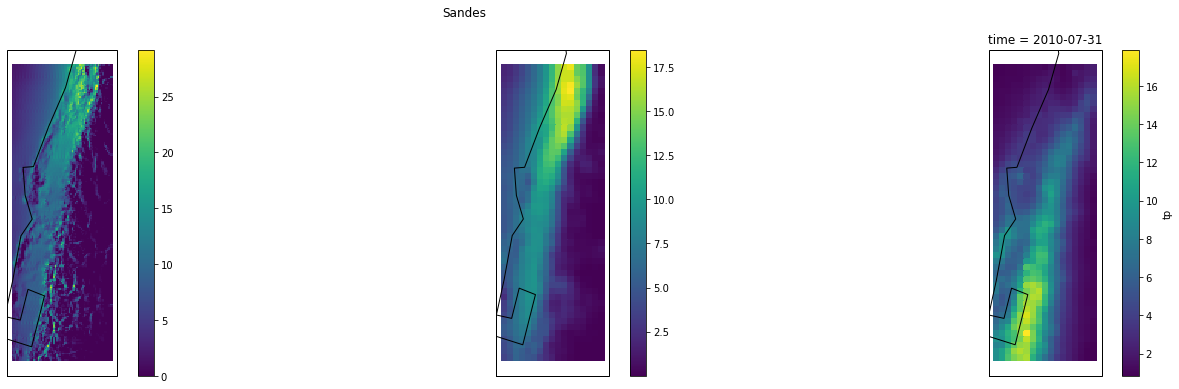

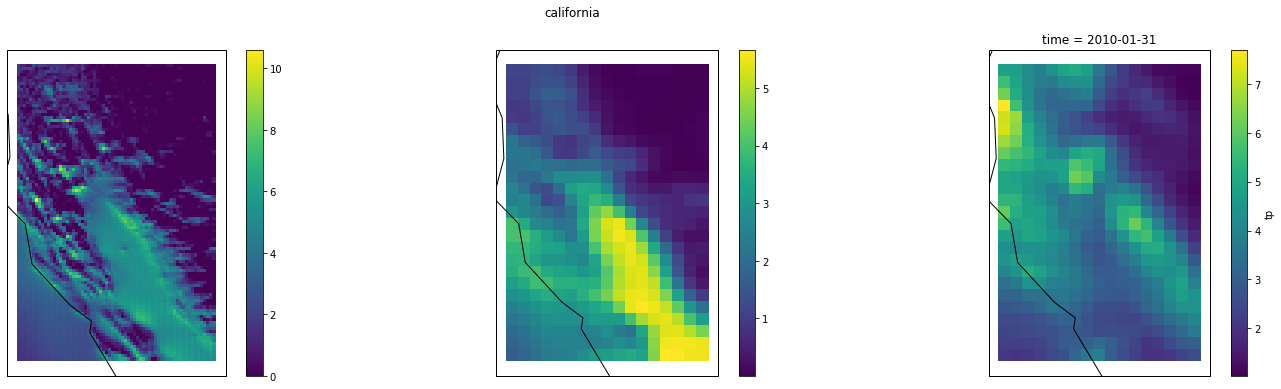

In [52]:
mnth={"nepal":"07",
      "Candes":"01",
      "Sandes":"07",
      "california":"01"}

for ct in ["nepal","Candes","Sandes","california"]:
    lonlat = box[ct]["small"]
    years = [str(n) for n in range(2010,2014)]
    pr      =0
    pr_era5 =0
    month = mnth[ct]
    for y in years :
        pr += full_linear_model_saturated_monthly(y+month,box[ct]["small"],fine_scale=True,lr_param=0.9)
        pr_era5 += xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/ERA5_IVT_tp_reanalysis_monthly_%s.nc"%y).tp.sel(time=pd.to_datetime(y+month,format='%Y%m')+MonthEnd(1)).sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))
        
    pr      /=len(years)
    pr_era5 /=len(years)  
    
    #pr = pr.isel(latitude = range(1,len(np.array(pr.latitude))-1),longitude = range(1,len(np.array(pr.longitude))-1))
    pr_coarse=xr.apply_ufunc(gaussian_filter,pr,kwargs={"sigma":3.}).interp_like(pr_era5)
    

    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})
    pr.plot(ax=ax1,transform=ccrs.PlateCarree())
    pr_coarse.plot(ax=ax2,transform=ccrs.PlateCarree())
    pr_era5.plot(ax=ax3,transform=ccrs.PlateCarree())
    ax1.coastlines();ax2.coastlines();ax3.coastlines()
    fig.suptitle(ct)
    
    